In [187]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import scipy.stats as st
from scipy.special import erf, gamma, gammainc

from scipy.optimize import minimize

import emcee
import corner

(0.0, 60.0)

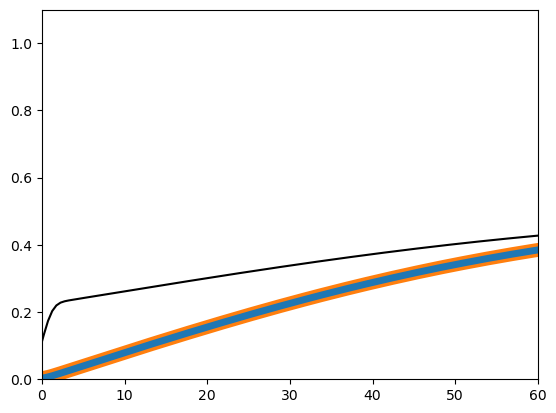

In [185]:
yy = np.linspace(-100, 100, 400)
dyI = .01
logL_SF = 10

s1 = 1
s2 = 50

a = 0
b = 0

I = [np.trapz((1 - st.norm.sf(np.arange(-10, yi, dyI) - -a, scale=s1))*st.norm.pdf(np.arange(-10, yi, dyI) - -b, scale=s2), dx=dyI) for i, yi in enumerate(yy)]
plt.plot(yy, I, lw=5)

I = [np.trapz((st.norm.cdf(np.arange(-10, yi, dyI) - -a, scale=s1))*st.norm.pdf(np.arange(-10, yi, dyI) - -b, scale=s2), dx=dyI) for i, yi in enumerate(yy)]
plt.plot(yy, I, lw=10, zorder=-1)

#I = 1/(2) * (st.norm.cdf(yy - -5, scale=s1) * st.norm.cdf(yy - -5, scale=s2))
#plt.plot(yy, I)

I = 1/2 * st.norm.cdf( (yy) / 1 ) * st.norm.cdf( (yy - np.sqrt(1*s2)) / np.sqrt(1 + s2**2) )

plt.plot(yy, I, color='k')

plt.ylim(0, 1.1)
plt.xlim(0, 60)


In [106]:
(s1**2 + s2**2)

5

In [84]:
s1**2 + s2**2

2

In [188]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = -1
Simbad.TIMEOUT = 800 # seconds

In [189]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

In [190]:
def f_X(x, x0, f_a=1, delta=1, theta=2.5):
    
    # Occupation function (Miller 2015)
    #focc = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (x - x0)))
    
    focc = 1/(1 + delta * np.exp(-theta*(x - x0)))**(1/delta)
    
    return f_a * focc

In [191]:
def log_likelihood(theta, x, y, xerr, yerr, logSFR, logSFRerr, xp, yp, d25, n, p_obs):
    
    # parameters to be fit
    log_ms0, alpha, beta, log_f, f_a, log_delta, theta2 = theta
    delta = np.exp(log_delta)

    mask_det = (yerr > 0)

    sigma_HX = 0.4

    # Residuals
    s2 = np.full(len(mask_det), np.exp(2*log_f)**2 + (beta*xerr)**2)
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (beta*xerr[mask_det])**2

    # XRB residuals
    s2_XRB = np.full(len(mask_det), sigma_HX**2 + xerr**2)
    s2_XRB[mask_det] = sigma_HX**2 + yerr[mask_det]**2 + xerr[mask_det]**2 + logSFRerr[mask_det]**2
    
    L_HX = 9.05*1e28 * 10**(x+xp) + 1.62*1e39 * 10**logSFR

    b = 2*n - 1/3
    logL_HX = np.log10(L_HX) - yp + np.log10(gammainc(2*n, b*(r_match.to(u.arcsec).value/(d25/2))**1/n)/gamma(2*n))

    # p(y|x) _BH
    f = st.norm.pdf(y - alpha - beta*x, scale=np.sqrt(s2))

    # Either the source is an XRB or a BH
    p_XRB = st.norm.sf(y - logL_HX, scale=np.sqrt(s2_XRB))
    
    # Likelihood
    S = st.norm.sf(-(y - alpha - beta*x), scale=np.sqrt(s2))

    # Occupation
    f_BHOF = f_X(x+xp, log_ms0+xp, f_a, delta, theta2)
    
    # Probability distribution
    p_det = (1 - p_XRB[mask_det]) * ( f_BHOF[mask_det] * f[mask_det] + p_XRB[mask_det])

    # https://math.stackexchange.com/questions/2040980/solving-approximating-integral-of-standard-normal-cdf

    # Numerical integration
    dyI = 0.1 # Change this to make sure nothing bad happens
    mask_pSF = p_XRB > 1e-14 # Short-cut
    I = np.ones_like(f_BHOF)
    I[~mask_det & mask_pSF] = [np.trapz((1 - st.norm.sf(np.arange(-10, yi, dyI) - logL_HX[~mask_det & mask_pSF][i], scale=np.sqrt(s2_XRB[~mask_det & mask_pSF][i])))*st.norm.pdf((np.arange(-10, yi, dyI) - alpha - beta*x[~mask_det & mask_pSF][i]), scale=np.sqrt(s2[~mask_det & mask_pSF][i])), dx=dyI) for i, yi in enumerate(y[~mask_det & mask_pSF])]
    I[~mask_det & ~mask_pSF] = S[~mask_det & ~mask_pSF]
    p_cens = f_BHOF[~mask_det] * I[~mask_det] + (1 - f_BHOF[~mask_det])

    # Clip
    # try + p_SF
    p_det = np.clip(p_obs[mask_det] * p_det, 1e-12, 1)
    p_cens = np.clip(p_obs[~mask_det] * p_cens, 1e-12, 1)
    
    # Likelihood
    ll_det = np.log(p_det)
    ll_cens = np.log(p_cens) + (1 - f_BHOF[~mask_det])

    ll = np.sum(ll_det) + np.sum(ll_cens)
    
    return ll

def log_likelihood_init(theta, x, y, xerr, yerr):
    
    # parameters to be fit
    alpha, beta, log_f = theta

    #if beta < 0:
    #    return -np.inf

    sigma2 = yerr**2 + np.exp(2*log_f)**2 + (beta*xerr)**2
    z = (y - alpha - beta*x)/np.sqrt(sigma2)
    
    mask_det = (yerr > 0)
    
    f = 1/np.sqrt(sigma2*2*np.pi)*np.exp(-z**2/2)
    
    ll = np.sum(np.log(f[mask_det]))
    
    return ll

In [192]:
def log_prior(theta):
    
    logms0, alpha, beta, log_f, f_a, log_a, pl1 = theta
        
    # Priors
    if -4.0 < logms0 < 5.0 and -5.0 < alpha < 5.0 and -1.0 < beta < 5.0 and -2.0 < log_f < 1.0 and 0 < f_a < 1 and -1 < log_a < 4 and 0.01 < pl1 < 50:
      return 0.0
    return -np.inf

### Chandra Source Catalog 2

In [200]:
hdul = fits.open('catalog.fits')
data_50Mpc = Table(hdul[1].data)
cat_50Mpc = SkyCoord(data_50Mpc['ra'], data_50Mpc['dec'], unit='deg')

table_csc = Table([cat_50Mpc.ra.deg, cat_50Mpc.dec.deg], names=['ra', 'dec'])
table_csc.write('table_csc.xml', format='votable', overwrite=True)

###########################
r_match = 1.0*u.arcsec ####
###########################


In [201]:
data_50Mpc

objname,pgc,nsaid,group_id,ra,dec,ra_nsa,dec_nsa,ra_ned,dec_ned,d25,v_h,v_cmb,v_source,hl_obj,lvg_obj,nsa_obj,sga_obj,t_type,color_type,best_type,a_B_leda,a_g_nsa,EBV_irsa,Bt0_leda,BV_color_leda,B_lum,gi_color_nsa,i_lum_nsa,gr_color_sga,r_lum_sga,BR_color_ned,R_lum_ned,BMag,gi_color,mag_flag,cf3_dist,cf3_dist_error,zind_dist,zind_dist_error,zind_indicator,bestdist,bestdist_error,bestdist_method,bestdist_source,dist_ned_flag,logmass_gi,logmass_gr,logmass_BV,logmass_BR,logmass,logmass_error,logmass_src,chandra_observation,chandra_detection,log_lx,chandra_detection_3arcsec,log_lx_3arcsec
str29,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,str6,str6,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,str32,int32,int32,float64,float64,float64,float64,float64,float64,str64,float64,float64,float64,float64,float64
2MASXJ01235631+0012308,3519080,114636,-1,20.984826,0.2084866,20.98477715,0.208338,20.98476,0.2085,0.4518559443749224,2396.68,2119.25,nsa,1.0,0.0,1.0,1.0,10.0,late,late,0.11352000000000001,0.09954,0.0262,16.961000000000002,nan,283903588.9420711,0.6306607471205918,253763377.28857803,0.4531887057861326,224319819.9721301,nan,nan,-15.69292720663945,0.6306607471205918,0.0,32.21672880740414,5.506498211637053,nan,nan,nan,32.217,5.506,CF3-Z,3,-1,8.166,8.234,nan,nan,8.166,0.15,g-i,0.0,0.0,nan,0.0,nan
2MASXJ04575930-0612323,3689848,-1,-1,74.4971145,-6.2089139,nan,nan,74.49712,-6.20889,nan,3012.0,3123.92,hyp,1.0,0.0,0.0,0.0,9.0,notype,late,0.19436,nan,0.0452,15.059,nan,2436816317.289007,nan,nan,nan,nan,nan,nan,-18.02705698525738,nan,nan,37.873844962917495,5.2713110095085085,nan,nan,nan,37.874,5.271,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ05534289-3205449,3704923,-1,-1,88.4288985,-32.0958874,nan,nan,88.42883,-32.09581,nan,2878.9,2858.64,hyp,1.0,0.0,0.0,0.0,9.0,notype,late,0.1419,nan,0.0328,16.191,nan,993914223.7061572,nan,nan,nan,nan,nan,nan,-17.05337226436726,nan,nan,41.734426780524835,5.581341249003874,nan,nan,nan,41.734,5.581,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ06094464-3250007,3707868,-1,-1,92.436063,-32.8336302,nan,nan,92.43604,-32.83361,nan,1417.7,1267.35,hyp,1.0,0.0,0.0,0.0,-3.0,notype,early,0.19436,nan,0.0447,15.363,nan,496387057.0462711,nan,nan,nan,nan,nan,nan,-16.299551122605276,nan,nan,19.662476859710292,6.8871789758103,nan,nan,nan,19.662,6.887,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ07415401+2352188,3723606,-1,-1,115.475523,23.8717641,nan,nan,115.47567,23.87175,0.5780960474057181,2269.3,1979.61,hyp,1.0,0.0,0.0,1.0,10.0,late,late,0.17114000000000001,nan,0.0395,15.972999999999999,nan,708288321.6268822,nan,nan,0.5239617447509772,547283615.0458648,nan,nan,-16.68552520284831,0.7377042218932411,nan,31.4396020713284,6.821081567051401,nan,nan,nan,31.44,6.821,CF3-Z,3,-1,nan,8.707,nan,nan,8.707,0.191,g-r,0.0,0.0,nan,0.0,nan
2MASXJ08241658+2710571,3729986,-1,-1,126.069153,27.182415,nan,nan,126.06919,27.18244,0.17298163592151014,962.9,1064.77,hyp,1.0,0.0,0.0,0.0,nan,notype,notype,0.14018,nan,0.0323,18.73,nan,13584592.284595454,nan,nan,nan,nan,nan,nan,-12.392616521090229,nan,nan,15.721258336507505,5.024527127250969,nan,nan,nan,15.721,5.025,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ09343407+1300201,3743904,532859,-1,143.642133,13.005688,143.64209443,13.00565104,143.64224,13.00574,nan,3052.56,3407.63,nsa,1.0,0.0,1.0,0.0,-2.4,notype,early,0.1118,0.0995,0.0258,16.569,nan,867293117.4852496,nan,nan,nan,nan,nan,nan,-16.905414750012355,nan,0.0,47.046026622834326,4.9279757630117516,nan,nan,nan,47.046,4.928,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan
2MASXJ09370295+6609161,3744472,403868,-1,144.262287,66.154824,144.26234289,66.15486662,144.26235,66.15494,nan,3384.45,3262.89,nsa,1.0,0.0,1.0,0.0,5.6,late,late,0.75766,0.67688,0.1755,15.818,nan,

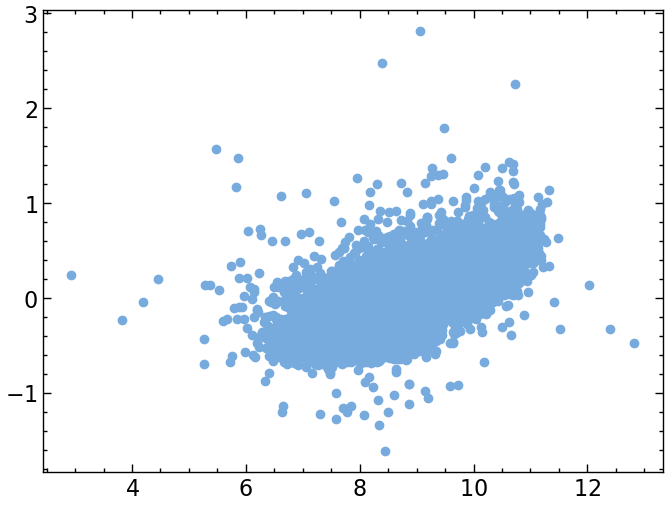

In [202]:
plt.scatter(data_50Mpc['logmass'], np.log10(data_50Mpc['d25']))

In [203]:
from astropy.io.votable import parse
csc_results = parse("cscresults.9.vot").get_first_table().to_table(use_names_over_ids=True)
csc_results

usrid,separation,probability,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood_class,extent_flag,conf_flag,sat_src_flag,streak_src_flag,flux_aper_b,flux_aper_lolim_b,flux_aper_hilim_b,flux_aper_w,flux_aper_lolim_w,flux_aper_hilim_w,flux_aper_h,flux_aper_lolim_h,flux_aper_hilim_h,flux_aper_avg_b,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w
,arcsec,,,,,arcsec,arcsec,deg,,,,,,,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,object,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
45,0.31,0.06,2CXO J124003.1-114004,190.01308812117622,-11.667943174265986,0.40,0.34,88.7,7.55,TRUE,False,False,False,False,8.4e-15,7.5e-15,9.31e-15,--,--,--,6.45e-15,5.4e-15,7.44e-15,8.4e-15,7.5e-15,9.31e-15,--,--,--
54,0.23,0.70,2CXO J151500.9+552555,228.75386435576434,55.4320033773426,1.45,0.92,82.4,4.05,TRUE,False,False,False,False,4.16e-15,2.86e-15,5.4e-15,--,--,--,3.52e-15,2.05e-15,5e-15,4.16e-15,2.86e-15,5.4e-15,--,--,--
300,1.01,0.00,2CXO J060541.3-863753,91.42225818614372,-86.63160308051602,0.31,0.30,86.4,11.11,TRUE,False,False,False,False,3.43e-13,3.12e-13,3.73e-13,--,--,--,3.49e-13,3.15e-13,3.82e-13,3.43e-13,3.12e-13,3.73e-13,--,--,--
445,0.18,0.14,2CXO J141309.9-652020,213.29136957562935,-65.33916214078448,0.29,0.29,0.0,150.02,TRUE,False,True,False,False,4.02e-12,3.98e-12,4.05e-12,--,--,--,4e-12,3.96e-12,4.03e-12,4.07e-12,4.04e-12,4.1e-12,--,--,--
445,1.04,0.00,2CXO J141309.7-652020,213.29061467645204,-65.33904001428208,0.29,0.29,0.0,64.66,TRUE,True,True,False,False,3.32e-13,3.24e-13,3.39e-13,--,--,--,2.51e-13,2.41e-13,2.6e-13,3.21e-13,3.15e-13,3.26e-13,--,--,--
445,2.29,0.00,2CXO J141309.5-652021,213.28987281200455,-65.33942088234446,0.29,0.29,0.0,32.81,TRUE,True,True,False,False,9.48e-14,9.08e-14,9.89e-14,--,--,--,8.02e-14,7.51e-14,8.5e-14,1.05e-13,1.02e-13,1.08e-13,--,--,--
445,2.94,0.00,2CXO J141308.5-652017X,213.2896569327,-65.33867745949,2.04,2.04,0.0,157.48,TRUE,True,--,--,True,--,--,--,--,--,--,--,--,--,1.88e-12,1.87e-12,1.89e-12,--,--,--
445,3.11,0.00,2CXO J141310.3-652022,213.2930451482107,-65.3395829899494,0.30,0.30,69.4,21.52,TRUE,False,True,False,False,0,0,3.56e-16,--,--,--,0,0,5.48e-16,7.28e-14,6.96e-14,7.58e-14,--,--,--


In [204]:
#names = 'c.usrid,c.separation,c.probability,m.name,m.ra,m.dec,m.err_ellipse_r0,m.err_ellipse_r1,m.err_ellipse_ang,m.significance,m.likelihood_class,s.extent_code,m.conf_flag,m.sat_src_flag,m.streak_src_flag,m.flux_aper_b,m.flux_aper_lolim_b,m.flux_aper_hilim_b,m.flux_aper_w,m.flux_aper_lolim_w,m.flux_aper_hilim_w,m.flux_aper_avg_b,m.flux_aper_avg_lolim_b,m.flux_aper_avg_hilim_b,flux_aper_h,flux_aper_lolim_h,flux_aper_hilim_h,flux_aper_avg_h,flux_aper_avg_hilim_h,flux_aper_avg_lolim_h,flux_aper_avg_w,m.flux_aper_avg_lolim_w,m.flux_aper_avg_hilim_w'.split(',')
#csc_results = Table.read('cscresults.6.vot')
#csc_results = Table(csc_results, names=names)

# New
from astropy.io.votable import parse
csc_results = parse("cscresults.9.vot").get_first_table().to_table(use_names_over_ids=True)
csc_results

# Compact only
mask = csc_results['extent_flag'] == 0
csc_results = csc_results[mask]

# Re-do the matching
cat_result = SkyCoord(csc_results['ra'], csc_results['dec'], unit='deg')
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, r_match)

#TODO: Why are there multiple h for unique _b

# These are stacked fluxes
fx = csc_results['flux_aper_h'][idx_result].data.data
fx_lo = csc_results['flux_aper_lolim_h'][idx_result].data.data
fx_hi = csc_results['flux_aper_hilim_h'][idx_result].data.data

print(len(csc_results))

fx_err = np.nanmean([fx-fx_lo, fx_hi-fx], axis=0)

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
# TODO dist err
log_lx_idx_result = np.log10(fx*4*np.pi*d**2)
log_lx_err_idx_result = 0.434*fx_err*4*np.pi*d**2 / 10**log_lx_idx_result
data_50Mpc['log_lx_csc'] = -1.0
data_50Mpc['log_lx_err_csc'] = -1.0

data_50Mpc['log_lx_csc'][idx_50Mpc] = log_lx_idx_result
data_50Mpc['log_lx_err_csc'][idx_50Mpc] = log_lx_err_idx_result

print(len(data_50Mpc['log_lx_csc'][data_50Mpc['log_lx_csc']>0]))
# 

737
257


/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31573/1676318741.py:27: RuntimeWarning: Mean of empty slice
  fx_err = np.nanmean([fx-fx_lo, fx_hi-fx], axis=0)
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31573/1676318741.py:31: RuntimeWarning: divide by zero encountered in log10
  log_lx_idx_result = np.log10(fx*4*np.pi*d**2)
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31573/1676318741.py:32: RuntimeWarning: divide by zero encountered in divide
  log_lx_err_idx_result = 0.434*fx_err*4*np.pi*d**2 / 10**log_lx_idx_result


In [205]:
#names = 'usrid	ra	dec	sr	flux_sens_b	flux_sens_h	flux_sens_m	flux_sens_s	flux_sens_w	photflux_sens_b	photflux_sens_h	photflux_sens_m	photflux_sens_s	photflux_sens_w	flux_sens_true_b	flux_sens_true_h	flux_sens_true_m	flux_sens_true_s	flux_sens_true_w	photflux_sens_true_b	photflux_sens_true_h	photflux_sens_true_m	photflux_sens_true_s	photflux_sens_true_w'.split('\t')
#csc_results_sens = Table.read('csclimsen.vot')
#csc_results_sens = Table(csc_results_sens, names=names)

# New
from astropy.io.votable import parse
csc_results_sens = parse("csclimsen.vot").get_first_table().to_table(use_names_over_ids=True)

csc_results_sens = csc_results_sens[np.isfinite(csc_results_sens['flux_sens_h'])]
# Re-do the matching
cat_result = SkyCoord(csc_results_sens['ra'], csc_results_sens['dec'], unit='deg')
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, r_match)

# Includes marginal detections
# Stacked upper limits?
d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
log_lx_sens_idx_result = np.log10(csc_results_sens['flux_sens_h'][idx_result]*4*np.pi*d**2)
#log_lx_sens_idx_result[~np.isfinite(log_lx_sens_idx_result)] = np.log10(1e-13*4*np.pi*d[~np.isfinite(log_lx_sens_idx_result)]**2) # ROSAT limit

data_50Mpc['log_lx_sens'] = -1.0
data_50Mpc['log_lx_sens'][idx_50Mpc] = log_lx_sens_idx_result


################# 
csc_results = parse("cscresults.9.vot").get_first_table().to_table(use_names_over_ids=True)
csc_results

# Extended detections
mask = csc_results['extent_flag'] != 0
csc_results = csc_results[mask]
# Re-do the matching
cat_result = SkyCoord(csc_results['ra'], csc_results['dec'], unit='deg')
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, r_match)


# These are stacked fluxes
d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
fx = np.log10(csc_results['flux_aper_h'][idx_result].data.data*4*np.pi*d**2)

# NOTE: Limiting sensitivity is computed within 1" of the galaxy coordinates, but that's ok 
# Because there is no detection within 5"

In [206]:
csc_results

usrid,separation,probability,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood_class,extent_flag,conf_flag,sat_src_flag,streak_src_flag,flux_aper_b,flux_aper_lolim_b,flux_aper_hilim_b,flux_aper_w,flux_aper_lolim_w,flux_aper_hilim_w,flux_aper_h,flux_aper_lolim_h,flux_aper_hilim_h,flux_aper_avg_b,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w
,arcsec,,,,,arcsec,arcsec,deg,,,,,,,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2,erg/s/cm^2
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,object,bool,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
445,1.04,0.00,2CXO J141309.7-652020,213.29061467645204,-65.33904001428208,0.29,0.29,0.0,64.66,TRUE,True,True,False,False,3.32e-13,3.24e-13,3.39e-13,--,--,--,2.51e-13,2.41e-13,2.6e-13,3.21e-13,3.15e-13,3.26e-13,--,--,--
445,2.29,0.00,2CXO J141309.5-652021,213.28987281200455,-65.33942088234446,0.29,0.29,0.0,32.81,TRUE,True,True,False,False,9.48e-14,9.08e-14,9.89e-14,--,--,--,8.02e-14,7.51e-14,8.5e-14,1.05e-13,1.02e-13,1.08e-13,--,--,--
445,2.94,0.00,2CXO J141308.5-652017X,213.2896569327,-65.33867745949,2.04,2.04,0.0,157.48,TRUE,True,--,--,True,--,--,--,--,--,--,--,--,--,1.88e-12,1.87e-12,1.89e-12,--,--,--
528,3.45,0.21,2CXO J161549.7-604811,243.95702878994803,-60.803232304648404,6.77,4.39,117.4,5.70,TRUE,True,False,False,False,6.2e-14,4.58e-14,7.81e-14,--,--,--,3.16e-14,1.39e-14,4.94e-14,6.2e-14,4.58e-14,7.81e-14,--,--,--
534,1.99,0.00,2CXO J163514.0-580448X,248.8085189419,-58.0800769136,1.33,1.33,0.0,27.51,TRUE,True,--,--,False,--,--,--,--,--,--,--,--,--,5.23e-13,5.03e-13,5.41e-13,--,--,--
537,0.25,0.04,2CXO J165120.2-591404,252.83438891525248,-59.234522109426024,0.29,0.29,0.0,57.12,TRUE,True,False,False,False,1.53e-12,1.51e-12,1.56e-12,--,--,--,1.31e-12,1.28e-12,1.34e-12,1.53e-12,1.51e-12,1.56e-12,--,--,--
1124,1.37,0.01,2CXO J125012.1-413052,192.5508050657645,-41.514624486261305,1.26,1.03,145.4,6.62,TRUE,True,False,False,False,3.39e-14,2.87e-14,3.89e-14,--,--,--,2.33e-14,1.72e-14,2.91e-14,3.29e-14,2.77e-14,3.82e-14,--,--,--
1581,0.55,0.00,2CXO J071631.2-291928,109.1299593833927,-29.32465898316955,0.30,0.29,127.7,53.77,TRUE,True,False,False,False,4.09e-13,3.98e-13,4.2e-13,--,--,--,3.33e-13,3.2e-13,3.47e-13,3.66e-13,3.59e-13,3.73e-13,--,--,--


(array([1.5139e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 3.2000e+01, 1.0800e+02,
        7.1000e+01, 3.5000e+01, 8.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
        12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.,
        25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
        38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.]),
 <BarContainer object of 50 a

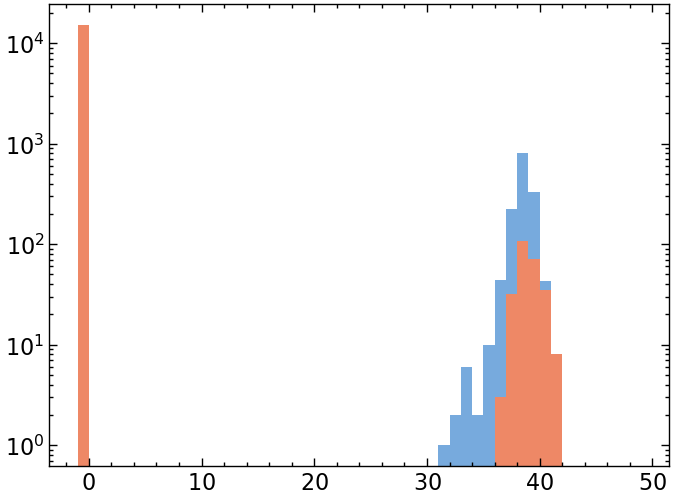

In [207]:
plt.hist(data_50Mpc['log_lx_sens'], log=True, bins=np.arange(-1, 50, 1))
plt.hist(data_50Mpc['log_lx_csc'], log=True, bins=np.arange(-1, 50, 1))

In [208]:
# amuse vs. CSC

### XMM-SSC DR16 

In [209]:
result_table = Vizier(catalog="xmm4d13s", timeout=3600,
                      columns=['RA_ICRS', 'DE_ICRS', 'Flux8', 'e_Flux8'], column_filters={'Flux8':'>0'}).query_region(cat_50Mpc, radius=1*u.arcsec)
result_table[0]

_q,RA_ICRS,DE_ICRS,Flux8,e_Flux8
,deg,deg,mW / m2,mW / m2
int32,float64,float64,float64,float64
89,190.013035,-11.667881,1.0645e-14,3.8631e-15
901,280.888255,-64.106998,2.9622e-14,1.1888e-14
1073,252.834470,-59.234537,2.9356e-12,2.3458e-14
2059,116.891920,-41.451866,7.108e-13,3.2925e-14
2143,178.298906,-39.130202,1.191e-13,6.9283e-15
2247,192.551452,-41.514992,2.9969e-14,3.284e-15
2891,203.974066,-34.295502,7.7694e-11,2.879e-14
3445,194.437219,-29.766195,2.1104e-13,1.423e-14


In [210]:
# Re-do the matching

cat_result = SkyCoord(result_table[0]['RA_ICRS'], result_table[0]['DE_ICRS'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 1.0*u.arcsec)

data_50Mpc['log_lx_xmm'] = -1.0
data_50Mpc['log_lx_err_xmm'] = -1.0

fx = result_table[0]['Flux8'][idx_result].data.data
fx_err = result_table[0]['e_Flux8'][idx_result].data.data

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
# TODO dist err
log_lx_idx_result = np.log10(fx*4*np.pi*d**2)
log_lx_err_idx_result = 0.434*fx_err*4*np.pi*d**2 / 10**log_lx_idx_result

data_50Mpc['log_lx_xmm'][idx_50Mpc] = log_lx_idx_result
data_50Mpc['log_lx_err_xmm'][idx_50Mpc] = log_lx_err_idx_result

### EROSITA detections / upper-limits

https://erosita.mpe.mpg.de/dr1/erodat/upperlimit/multi/

In [211]:
result_table = Vizier(catalog="J/A+A/682/A34/erass1-m", timeout=3600,
                      columns=['RA_ICRS', 'DE_ICRS', 'MLFluxP5', 's_MLFluxP5'], column_filters={'MLFluxP5':'>0'}).query_region(cat_50Mpc, radius=1*u.arcsec)
result_table[0]

_q,RA_ICRS,DE_ICRS,MLFluxP5,s_MLFluxP5
,deg,deg,mW / m2,mW / m2
int32,float64,float64,float64,float64
449,252.17068013795,-62.60612923082,7.3531323e-13,7.7292496e-13
1446,203.97385382684,-34.29560324026,2.9913398e-11,1.4227849e-11
2107,221.23720360970,-23.79445759244,1.6211544e-12,9.843941e-13
3406,23.57559085092,-29.41826075242,1.5780355e-12,1.3403941e-12
3582,53.40137891006,-36.14039526280,6.9527791e-12,1.4603142e-12
3605,54.62137759849,-35.45045581437,6.8061231e-13,7.2621867e-13
3672,65.00126725329,-54.93786901848,2.5202195e-12,7.395401e-13
4007,149.87314760041,-22.82618779699,1.7151233e-12,1.3312083e-12


In [212]:
# Re-do the matching

cat_result = SkyCoord(result_table[0]['RA_ICRS'], result_table[0]['DE_ICRS'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 1.0*u.arcsec)

data_50Mpc['log_lx_erosita'] = -1.0
data_50Mpc['log_lx_err_erosita'] = -1.0

fx = result_table[0]['MLFluxP5'][idx_result].data.data
fx_err = result_table[0]['s_MLFluxP5'][idx_result].data.data

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
# TODO dist err
log_lx_idx_result = np.log10(fx*4*np.pi*d**2)
log_lx_err_idx_result = 0.434*fx_err*4*np.pi*d**2 / 10**log_lx_idx_result

data_50Mpc['log_lx_erosita'][idx_50Mpc] = log_lx_idx_result
data_50Mpc['log_lx_err_erosita'][idx_50Mpc] = log_lx_err_idx_result

In [213]:
# Exclude sources without upper-limit or flux measurement from Chandra or XMM observations 
print(len(table_csc[(data_50Mpc['log_lx_csc']==-1) & (data_50Mpc['log_lx_erosita']==-1) & (data_50Mpc['log_lx_xmm']==-1)]))

table_csc[(data_50Mpc['log_lx_csc']==-1) & (data_50Mpc['log_lx_erosita']==-1) & (data_50Mpc['log_lx_xmm']==-1)].write('table_erosita.txt',
                                                                                   format='ascii', overwrite=True, names=None)

15019


### ROSAT detections / upper-limits

In [214]:
# The rest can assume limits of +99
result_table = Vizier(catalog="J/A+A/588/A103/cat2rxs", timeout=3600,
                      columns=['RAJ2000', 'DEJ2000', 'Fluxp'], column_filters={'Fluxp':'>0'}).query_region(cat_50Mpc, radius=5*u.arcsec)
result_table[0]

_q,RAJ2000,DEJ2000,Fluxp
,deg,deg,mW / m2
int32,float64,float64,float32
75,65.32997,-31.63378,3.818e-13
1446,203.97544,-34.29518,9.786e-11
1628,146.91835,-30.94832,3.025e-11
1997,159.45606,-27.12092,8.481e-11
3358,11.88857,-25.28862,5.968e-12
3404,23.46219,30.65916,2.323e-11
3485,40.67058,-0.01361,6.926e-11
3672,65.00302,-54.93771,4.411e-12


In [215]:
# Re-do the matching

cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 1.0*u.arcsec)

data_50Mpc['log_lx_rosat'] = -1.0
data_50Mpc['log_lx_err_rosat'] = -1.0

fx = result_table[0]['Fluxp'][idx_result].data.data
fx_err = 0.1*fx

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
# TODO dist err
log_lx_idx_result = np.log10(fx*4*np.pi*d**2)
log_lx_err_idx_result = 0.434*fx_err*4*np.pi*d**2 / 10**log_lx_idx_result

data_50Mpc['log_lx_rosat'][idx_50Mpc] = log_lx_idx_result
data_50Mpc['log_lx_err_rosat'][idx_50Mpc] = log_lx_err_idx_result

### Combine X-ray data

In [216]:
#data_50Mpc['log_lx_xmm'][data_50Mpc['_log_lx']==-1]

In [217]:
len(data_50Mpc['log_lx_csc'][data_50Mpc['log_lx_csc']>0])

257

In [218]:
6.5*1e-15*u.cm**-2*u.erg/u.s * 4 *np.pi * (50*u.Mpc).to(u.cm)**2

<Quantity 1.94430467e+39 erg / s>

In [219]:
data_50Mpc['_log_lx'] = data_50Mpc['log_lx_csc']
print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))
#data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_xmm'][data_50Mpc['_log_lx']==-1]
#print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))
#data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_erosita'][data_50Mpc['_log_lx']==-1]
#print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))

data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_rosat'][data_50Mpc['_log_lx']==-1]


data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_sens'][data_50Mpc['_log_lx']==-1]
#print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))
#print(len(data_50Mpc['_log_lx']))

# Now, go to ROSAT 2RXS
d = (data_50Mpc['bestdist'][data_50Mpc['_log_lx']==-1]*u.Mpc).to(u.cm).value
data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = np.log10(1e-13*4*np.pi*d**2)
#TODO: Use detections here too


data_50Mpc['_log_lx_err'] = data_50Mpc['log_lx_err_csc']
# Treat other detections these as upper limits
#data_50Mpc['_log_lx_err'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_err_xmm'][data_50Mpc['_log_lx']==-1]
#data_50Mpc['_log_lx_err'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_err_erosita'][data_50Mpc['_log_lx']==-1]


257


277


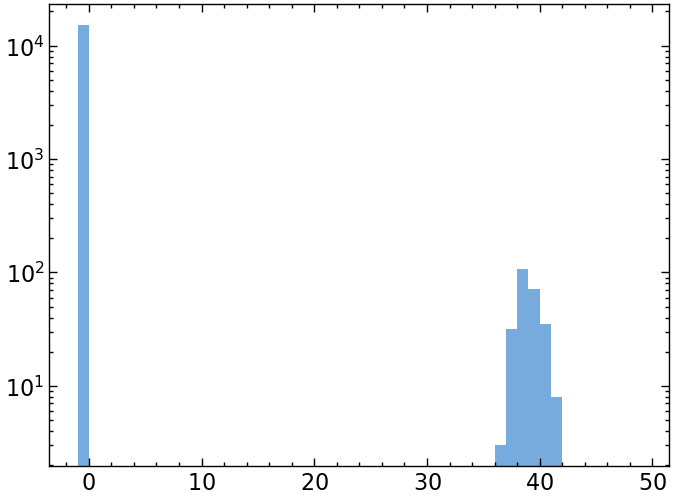

In [220]:
plt.hist(data_50Mpc['log_lx_csc'], log=True, bins=np.arange(-1, 50, 1))
print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx_err']>0]))

### Remove high-z interlopers

In [221]:
result_table = Vizier(catalog="V/154/sdss16", timeout=400).query_region(cat_50Mpc, radius=0.5*u.arcsec)
result_table[0]

_q,objID,RA_ICRS,DE_ICRS,mode,class,clean,e_RA_ICRS,e_DE_ICRS,umag,gmag,rmag,imag,zmag,e_umag,e_gmag,e_rmag,e_imag,e_zmag,zsp,e_zsp,f_zsp,zph,e_zph,__zph_,Q,SDSS16,Sp-ID,_tab1_130
,,deg,deg,,,,arcsec,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,,,,,d
int32,int64,float64,float64,uint8,uint8,uint8,float64,float64,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,int16,float32,float32,float32,uint8,str24,str16,float64
1,1237646011629174917,20.984799,0.208487,3,3,0,0.019,0.035,17.780,16.842,16.456,16.269,16.107,0.019,0.005,0.005,0.005,0.017,--,--,--,--,--,--,3,SDSS J012356.35+001230.5,,51081.3415
1,1237646011629174918,20.984798,0.208487,2,3,0,0.019,0.035,17.836,16.852,16.465,16.287,16.122,0.020,0.005,0.005,0.005,0.017,--,--,--,--,--,--,3,SDSS J012356.35+001230.5,,51081.3415
1,1237646505539600533,20.984801,0.208487,3,3,0,0.017,0.046,17.868,16.852,16.431,16.250,16.118,0.018,0.004,0.005,0.006,0.021,--,--,--,--,--,--,3,SDSS J012356.35+001230.5,,51132.2024
1,1237646505539600534,20.984787,0.208482,3,3,0,0.017,0.045,17.878,16.873,16.447,16.282,16.148,0.017,0.005,0.005,0.006,0.021,--,--,--,--,--,--,3,SDSS J012356.34+001230.5,,51132.2024
1,1237646505539600535,20.984787,0.208482,4,3,0,0.017,0.045,17.878,16.873,16.447,16.282,16.148,0.017,0.005,0.005,0.006,0.021,--,--,--,--,--,--,3,SDSS J012356.34+001230.5,,51132.2024
1,1237646647275159646,20.984780,0.208492,2,3,0,0.018,0.060,17.873,16.897,16.502,16.229,16.259,0.017,0.004,0.005,0.006,0.020,--,--,--,--,--,--,3,SDSS J012356.34+001230.5,,51136.1918
1,1237656512815825014,20.984787,0.208457,3,3,0,0.020,0.066,17.884,16.884,16.486,16.278,16.088,0.026,0.005,0.006,0.033,0.023,--,--,--,--,--,--,3,SDSS J012356.34+001230.4,,52170.3789
1,1237656512815825015,20.984775,0.208460,3,3,0,0.020,0.068,17.845,16.891,16.491,16.282,16.132,0.020,0.005,0.006,0.033,0.021,--,--,--,--,--,--,3,SDSS J012356.34+001230.4,,52170.3789


In [222]:
# Remove sources with redshift > 0.012 (~51 Mpc)

mask_zsp = np.isfinite(result_table[0]['zsp'].data.data)
cat_result = SkyCoord(result_table[0]['RA_ICRS'][mask_zsp], result_table[0]['DE_ICRS'][mask_zsp])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 0.5*u.arcsec)

data_50Mpc['z_dr16'] = -1.0 # mJy
data_50Mpc['z_dr16'][idx_50Mpc] = result_table[0]['zsp'].data.data[mask_zsp][idx_result]

In [223]:
result_table = Vizier(catalog="J/MNRAS/474/3875/gamadr3", timeout=400).query_region(cat_50Mpc, radius=0.5*u.arcsec)
result_table[0]

_q,spectID,Survey,RAJ2000,DEJ2000,z,NQ,Prob,URL,URLimg,CataId,GAMA,Dist
,,,deg,deg,,,,,,,,arcsec
int32,str33,str9,float64,float64,float64,uint8,float32,str88,str92,int32,str23,float32
2560,6dFg0214095-064823,6dFGS,33.53942,-6.80633,0.00715,3,0.000,http://www.gama-survey.org/dr3/data/spectra/6dfgs/g0214095-064823.fit,http://www.gama-survey.org/dr3/data/spectra/6dfgs/png/g0214095-064823.png,2138298,GAMAJ021409.47-064822.6,0.29
2615,320975784472766464,SDSS,178.55114,0.13659,0.00378,2,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0285-51663-0343.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0285-51663-0343.png,70114,GAMAJ115412.26+000811.8,0.15
2615,320977163341817856,SDSS,178.55114,0.13659,0.00379,2,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0285-51930-0348.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0285-51930-0348.png,70114,GAMAJ115412.26+000811.8,0.15
2615,2dF298044,2dFGRS,178.55126,0.13661,0.00380,4,0.000,http://www.gama-survey.org/dr3/data/spectra/2dfgrs/298044.fit,http://www.gama-survey.org/dr3/data/spectra/2dfgrs/png/298044.png,70114,GAMAJ115412.26+000811.8,0.49
2645,340044064088942592,SDSS,212.18034,-1.16165,0.00415,5,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0302-51616-0081.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0302-51616-0081.png,496943,GAMAJ140843.28-010941.8,0.14
2645,340044889930622976,SDSS,212.18034,-1.16165,0.00415,2,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0302-51688-0084.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0302-51688-0084.png,496943,GAMAJ140843.28-010941.8,0.14
2645,1031416713540823040,SDSS,212.18039,-1.16161,0.00415,5,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0916-52378-0336.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0916-52378-0336.png,496943,GAMAJ140843.28-010941.8,0.10
3439,749860644005636096,SDSS,31.14511,-10.10847,0.00640,5,0.000,http://www.gama-survey.org/dr3/data/spectra/sdss/spec-0666-52149-0041.fit,http://www.gama-survey.org/dr3/data/spectra/sdss/png/spec-0666-52149-0041.png,2255550,GAMAJ020434.83-100630.1,0.37


In [224]:
# Remove sources with redshift > 0.012 (~51 Mpc)

mask_zsp = np.isfinite(result_table[0]['z'].data.data) & (result_table[0]['Prob'] > 0.0)
cat_result = SkyCoord(result_table[0]['RAJ2000'][mask_zsp], result_table[0]['DEJ2000'][mask_zsp])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 0.5*u.arcsec)

data_50Mpc['z_gama'] = -1.0 # mJy
data_50Mpc['z_gama'][idx_50Mpc] = result_table[0]['z'].data.data[mask_zsp][idx_result]

In [225]:
# the flux density measurements are likely underestimated by an average of ~15%.
# Additionally the astrometry is typically only accurate to ~0.25"

result_table = Vizier(catalog="J/ApJS/255/30").query_region(cat_50Mpc, radius=2.5*u.arcsec)
result_table[0]

_q,CompName,CompId,RAJ2000,DEJ2000,Ftot,e_Ftot,Fpeak,e_Fpeak,Islrms,SCode,DCMaj,DCMin,DCPA,Subtile,NVSSdist,FIRSTdist,PeakToRing,DupFlag,QualFlag,NNdist,MainSample,QLcutout
,,,deg,deg,mJy,mJy,mJy / beam,mJy / beam,mJy / beam,,arcsec,arcsec,deg,,arcsec,arcsec,,,,arcsec,,
int32,str31,int16,float64,float64,float64,float32,float64,float32,float32,str1,float64,float64,float64,str14,float64,float64,float64,uint8,uint8,float64,uint8,str237
141,VLASS1QLCIR J034227.81-260242.1,58,55.61589526,-26.04504514,20.790,0.237,17.376,0.119,0.118,S,0.0000,0.0000,0.0000,J034428-263000,2.15587,65364.28105,38.3879,0,0,223.41000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T04t06.J034428-263000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dmts17nwzt3fm0gs3&CIRCLE=55.61589525764924+-26.04504513891315+0.025
149,VLASS1QLCIR J042119.40-313803.8,25,65.33085795,-31.63440925,7.522,0.301,5.804,0.143,0.140,S,1.5667,0.8329,10.4173,J042059-313000,1.19014,90338.72228,12.6292,0,0,119.42000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.2.ql.T03t07.J042059-313000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dtoqjqfxjg5zix704&CIRCLE=65.33085795299331+-31.63440925291232+0.025
209,VLASS1QLCIR J113858.91-380041.7,20,174.74548204,-38.01158462,5.810,0.205,5.610,0.107,0.117,S,0.0000,0.0000,0.0000,J113730-373000,2.03022,107678.95046,7.8130,2,0,--,0,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t24.J113730-373000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dxpoy2fevt8o4n95n&CIRCLE=174.7454820365871+-38.01158461806799+0.025
209,VLASS1QLCIR J113858.91-380041.5,20,174.74549515,-38.01154557,7.426,0.287,6.543,0.117,0.117,M,0.0000,0.0000,0.0000,J113736-383000,2.09508,107678.81041,9.7721,1,0,5.42000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t24.J113736-383000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dxpoy2fevt8o4n95n&CIRCLE=174.7454951544545+-38.0115455701324+0.025
2087,VLASS1QLCIR J102302.30-390958.9,-20,155.75960482,-39.16638292,0.000,0.000,0.851,0.000,0.132,E,0.0000,0.0000,0.0000,J102309-393000,9.59216,111902.86191,1.7536,0,4,--,0,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t21.J102309-393000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dezqb4d5uv94smudb&CIRCLE=155.75960482333562+-39.16638291798394+0.025
2095,VLASS1QLCIR J102442.46-391820.1,13,156.17692379,-39.30560615,39.231,0.545,21.460,0.145,0.145,M,3.7062,1.5912,176.6384,J102309-393000,0.29267,112395.19731,10.8439,0,0,205.27000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t21.J102309-393000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dezqb4d5uv94smudb&CIRCLE=156.17692379128897+-39.30560615175234+0.025
2143,VLASS1QLCIR J115311.69-390747.8,29,178.29873486,-39.12995280,55.213,1.059,28.760,0.132,0.132,M,4.5661,2.9395,158.7895,J115309-393000,1.08510,111764.34273,8.4293,0,0,69.56000,1,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.1.ql.T01t24.J115309-393000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dfimknc0sxv3aj0yq&CIRCLE=178.298734858874+-39.12995280479714+0.025
2153,VLASS1QLCIR J121142.15-383253.6,38,182.92565030,-38.54824839,2.116,0.400,1.223,0.156,0.146,S,3.0413,0.9012,68.2883,J121241-383000,4.35020,109602.39851,1.8298,0,1,294.64000,0,https://ws.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/caom2ops/sync?ID=ad%3AVLASS%2FVLASS1.2.ql.T01t25.J121241-383000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits&RUNID%3Dsag9hmrdnzlixild&CIRCLE=182.92565030246647+-38.54824838574661+0.025


In [226]:
mask_point = result_table[0]['DCMaj'] < 0.5

cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result[mask_point], 5*u.arcsec)

d = (data_50Mpc['bestdist']*u.Mpc).to(u.cm).value

data_50Mpc['Ftot'] = 2.1 # mJy
data_50Mpc['e_Ftot'] = -1.0 # mJy
data_50Mpc['Ftot'][idx_50Mpc] = result_table[0]['Ftot'][mask_point][idx_result]
data_50Mpc['e_Ftot'][idx_50Mpc] = result_table[0]['e_Ftot'][mask_point][idx_result]

data_50Mpc['log_l_vlass'] = np.log10(4*np.pi*data_50Mpc['Ftot']*d**2)
data_50Mpc['l_vlass_err'] = 4*np.pi*data_50Mpc['e_Ftot']*d**2 

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31573/9378452.py:13: RuntimeWarning: divide by zero encountered in log10
  data_50Mpc['log_l_vlass'] = np.log10(4*np.pi*data_50Mpc['Ftot']*d**2)


### Estimate SFR (from IR+GALEX photometry)

In [227]:

result_table = Vizier(catalog="II/335/galex_ais", timeout=3200).query_region(cat_50Mpc, radius=1.5*u.arcsec)
result_table[0]

_q,RAJ2000,DEJ2000,Name,r.fov,b,FUVmag,e_FUVmag,NUVmag,e_NUVmag,Fafl,Nafl,Fexf,Nexf,Fr,Nr
,deg,deg,,deg,,mag,mag,mag,mag,,,,,deg,deg
int32,float64,float64,str22,float64,uint8,float64,float32,float64,float32,int16,int16,int16,int16,float64,float64
1,20.984840,0.208705,GALEX J012356.3+001231,0.493530,3,19.3336,0.0894,19.0963,0.0560,0,4,0,0,0.003873,0.003523
9,144.643587,8.887482,GALEX J093834.4+085314,0.180932,1,--,--,19.6750,0.1380,0,0,0,0,--,0.006759
11,146.911188,4.821743,GALEX J094738.6+044918,0.388633,3,18.2408,0.0581,17.8452,0.0294,0,0,0,0,0.004142,0.003098
12,150.466086,-28.510018,GALEX J100151.8-283036,0.280424,1,--,--,21.5350,0.4080,256,0,0,0,--,0.003891
13,155.288659,-32.861287,GALEX J102109.2-325140,0.314861,3,18.0158,0.0539,17.6303,0.0304,0,0,0,0,0.008448,0.008572
14,155.337559,-21.607707,GALEX J102121.0-213627,0.524461,3,17.3302,0.0329,17.0463,0.0207,0,17,0,0,0.002635,0.002347
18,158.327692,-15.773242,GALEX J103318.6-154623,0.363928,1,--,--,20.5295,0.1465,0,0,0,2,--,0.002024
21,159.738852,-20.045009,GALEX J103857.3-200242,0.498215,3,17.5337,0.0446,17.1285,0.0215,0,1,0,0,0.004102,0.004644


In [228]:
cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 1.5*u.arcsec)

data_50Mpc['NUV'] = -1.0
data_50Mpc['FUV'] = -1.0 # mJy
data_50Mpc['NUV'][idx_50Mpc] = result_table[0]['NUVmag'][idx_result]
data_50Mpc['FUV'][idx_50Mpc] = result_table[0]['FUVmag'][idx_result]

In [229]:

result_table = Vizier(catalog="II/328/allwise", timeout=3200).query_region(cat_50Mpc, radius=1.5*u.arcsec)
result_table[0]

_q,AllWISE,RAJ2000,DEJ2000,Im,W1mag,e_W1mag,W2mag,e_W2mag,W3mag,e_W3mag,W4mag,e_W4mag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,ccf,ex,var,pmRA,e_pmRA,pmDE,e_pmDE,qph,d2M,_2M
,,deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,mas / yr,mas / yr,mas / yr,mas / yr,,arcsec,
int32,str19,float64,float64,str2,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str4,uint8,str4,int32,int32,int32,int32,str4,float32,str2
1,J012356.34+001230.8,20.9847811,0.2085807,Im,14.595,0.030,14.463,0.052,11.507,0.220,8.539,0.317,--,--,--,--,--,--,0000,0,00nn,-319,127,-163,129,AABB,--,2M
3,J055342.92-320544.9,88.4288586,-32.0958166,Im,13.658,0.026,13.672,0.032,11.076,0.104,8.812,0.372,15.839,0.169,15.620,0.232,14.041,--,0h00,5,110n,-347,84,169,90,AAAC,0.899,2M
4,J060944.63-325001.4,92.4359878,-32.8337423,Im,12.931,0.027,12.881,0.027,10.017,0.048,7.784,0.156,15.415,0.138,14.866,0.189,14.529,0.136,h000,5,310n,486,67,306,67,AAAB,0.560,2M
6,J082416.60+271056.8,126.0692033,27.1824507,Im,14.214,0.027,13.990,0.040,11.977,--,8.973,--,15.795,0.091,15.130,0.096,14.530,0.075,0000,0,01nn,54,125,62,138,AAUU,0.073,2M
7,J093434.08+130020.5,143.6420382,13.0057024,Im,14.056,0.040,14.018,0.059,11.078,0.223,8.052,--,16.242,0.155,15.470,0.160,14.838,0.132,dd00,5,10nn,-260,135,468,148,AABU,0.177,2M
9,J093834.46+085316.5,144.6436021,8.8879431,Im,11.524,0.023,11.596,0.021,10.053,0.065,8.355,0.290,13.452,0.064,12.847,0.079,12.586,0.065,0h00,5,000n,-235,47,-446,49,AAAB,0.251,2M
10,J094458.92+082211.6,146.2455214,8.3698967,Im,14.153,0.027,14.124,0.045,11.418,0.205,8.318,--,15.868,0.107,15.471,0.160,15.196,0.145,0000,0,00nn,23,142,79,153,AABU,0.282,2M
12,J100151.82-283037.2,150.4659410,-28.5103532,Im,12.701,0.024,12.710,0.023,9.993,0.053,8.766,0.504,14.618,0.094,14.168,0.110,13.579,0.079,0000,5,000n,9,76,82,81,AAAC,0.047,2M


In [230]:
# https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 5*u.arcsec)

data_50Mpc['W4mag'] = -1.0
data_50Mpc['W4mag'][idx_50Mpc] = result_table[0]['W4mag'][idx_result]

In [231]:
data_50Mpc.write('50Mpc_all.txt', format='csv', overwrite=True)

In [232]:
f_FUV = 1.40*1e-15 * 10**((data_50Mpc['FUV'] - 18.82)/-2.5)
f_IR = 8.363 * 10**(-data_50Mpc['W4mag']/2.5)

d = (data_50Mpc['bestdist']*u.Mpc).to(u.cm).value

L_FUV = np.full_like(f_FUV, -1.0)
L_IR = np.full_like(f_IR, -1.0)

L_FUV[data_50Mpc['FUV']>0] = (f_FUV*4*np.pi*d**2)[data_50Mpc['FUV']>0]
L_IR[data_50Mpc['W4mag']>0] = (f_IR*4*np.pi*d**2)[data_50Mpc['W4mag']>0]

L_FUV = (L_FUV*u.erg/u.s/u.AA).to(u.erg/u.s, equivalencies=u.spectral_density(0.15*u.um))
L_IR = (L_IR*u.Jy*u.cm**2).to(u.erg/u.s, equivalencies=u.spectral_density(22*u.um))

L_FUV_corr = L_FUV + 3.89 * L_IR
data_50Mpc['logSFR'] = 0.873*data_50Mpc['logmass']-8.99 # https://iopscience.iop.org/article/10.3847/1538-4357/aa9790/pdf
data_50Mpc['logSFR'][L_FUV_corr>0] = np.log10(L_FUV_corr.value[L_FUV_corr>0]) - 43.35

#data_50Mpc['logSFR'] = 1*(data_50Mpc['logmass']-10.2) # Popesso
#data_50Mpc['logSFR'][L_IR>0] = np.log10(gamma * 9.8*1e-11*L_IR.value[L_IR>0])
data_50Mpc['logSFRerr'] = np.sqrt(0.3**2 + 0.3**2) # Large errors to start
# https://iopscience.iop.org/article/10.3847/1538-4357/aa9790/pdf
data_50Mpc['logSFRerr'][L_FUV_corr>0] = 0.3 # Large errors to start
#data_50Mpc['logSFRerr'][~np.isfinite(data_50Mpc['SFR'])] = np.full(len(L_IR), 0.13)[~np.isfinite(data_50Mpc['SFR'])]

(array([1.000e+00, 3.000e+00, 5.000e+00, 4.500e+01, 2.080e+02, 7.680e+02,
        1.393e+03, 8.260e+02, 2.390e+02, 5.000e+01]),
 array([-6.437348 , -5.6958218, -4.9542956, -4.2127694, -3.4712432,
        -2.729717 , -1.9881908, -1.2466646, -0.5051384,  0.2363878,
         0.977914 ]),
 <BarContainer object of 10 artists>)

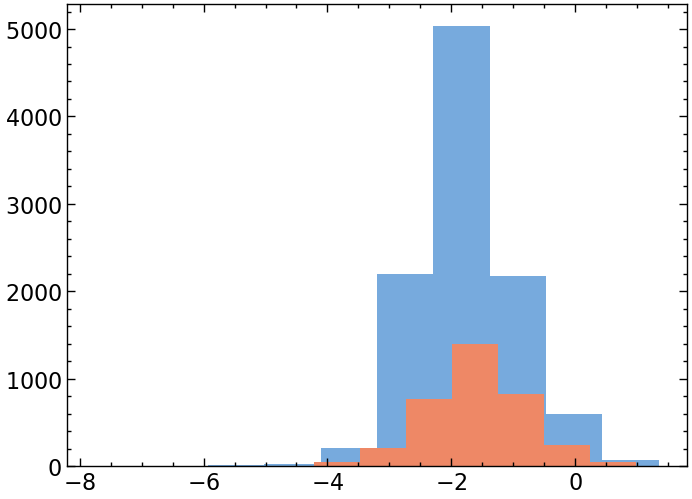

In [233]:
plt.hist(data_50Mpc['logSFR'][L_FUV_corr>0])
plt.hist(data_50Mpc['logSFR'][L_FUV_corr<0])

In [234]:
data_50Mpc

objname,pgc,nsaid,group_id,ra,dec,ra_nsa,dec_nsa,ra_ned,dec_ned,d25,v_h,v_cmb,v_source,hl_obj,lvg_obj,nsa_obj,sga_obj,t_type,color_type,best_type,a_B_leda,a_g_nsa,EBV_irsa,Bt0_leda,BV_color_leda,B_lum,gi_color_nsa,i_lum_nsa,gr_color_sga,r_lum_sga,BR_color_ned,R_lum_ned,BMag,gi_color,mag_flag,cf3_dist,cf3_dist_error,zind_dist,zind_dist_error,zind_indicator,bestdist,bestdist_error,bestdist_method,bestdist_source,dist_ned_flag,logmass_gi,logmass_gr,logmass_BV,logmass_BR,logmass,logmass_error,logmass_src,chandra_observation,chandra_detection,log_lx,chandra_detection_3arcsec,log_lx_3arcsec,log_lx_csc,log_lx_err_csc,log_lx_sens,log_lx_xmm,log_lx_err_xmm,log_lx_erosita,log_lx_err_erosita,log_lx_rosat,log_lx_err_rosat,_log_lx,_log_lx_err,z_dr16,z_gama,Ftot,e_Ftot,log_l_vlass,l_vlass_err,NUV,FUV,W4mag,logSFR,logSFRerr
str29,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,str6,str6,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,str32,int32,int32,float64,float64,float64,float64,float64,float64,str64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2MASXJ01235631+0012308,3519080,114636,-1,20.984826,0.2084866,20.98477715,0.208338,20.98476,0.2085,0.4518559443749224,2396.68,2119.25,nsa,1.0,0.0,1.0,1.0,10.0,late,late,0.11352000000000001,0.09954,0.0262,16.961000000000002,nan,283903588.9420711,0.6306607471205918,253763377.28857803,0.4531887057861326,224319819.9721301,nan,nan,-15.69292720663945,0.6306607471205918,0.0,32.21672880740414,5.506498211637053,nan,nan,nan,32.217,5.506,CF3-Z,3,-1,8.166,8.234,nan,nan,8.166,0.15,g-i,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,40.09408114866225,-1.0,-1.0,-1.0,2.1,-1.0,53.41630044339617,-1.2418843341135047e+53,19.0963,19.3336,8.538999557495117,-1.77719279762443,0.3
2MASXJ04575930-0612323,3689848,-1,-1,74.4971145,-6.2089139,nan,nan,74.49712,-6.20889,nan,3012.0,3123.92,hyp,1.0,0.0,0.0,0.0,9.0,notype,late,0.19436,nan,0.0452,15.059,nan,2436816317.289007,nan,nan,nan,nan,nan,nan,-18.02705698525738,nan,nan,37.873844962917495,5.2713110095085085,nan,nan,nan,37.874,5.271,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,40.23459330414239,-1.0,-1.0,-1.0,2.1,-1.0,53.55681259887631,-1.7163004017413258e+53,-1.0,-1.0,-1.0,nan,0.4242640687119285
2MASXJ05534289-3205449,3704923,-1,-1,88.4288985,-32.0958874,nan,nan,88.42883,-32.09581,nan,2878.9,2858.64,hyp,1.0,0.0,0.0,0.0,9.0,notype,late,0.1419,nan,0.0328,16.191,nan,993914223.7061572,nan,nan,nan,nan,nan,nan,-17.05337226436726,nan,nan,41.734426780524835,5.581341249003874,nan,nan,nan,41.734,5.581,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,40.31889097788811,-1.0,-1.0,-1.0,2.1,-1.0,53.64111027262203,-2.0839676734184817e+53,-1.0,-1.0,8.812000274658203,-1.909199411758955,0.3
2MASXJ06094464-3250007,3707868,-1,-1,92.436063,-32.8336302,nan,nan,92.43604,-32.83361,nan,1417.7,1267.35,hyp,1.0,0.0,0.0,0.0,-3.0,notype,early,0.19436,nan,0.0447,15.363,nan,496387057.0462711,nan,nan,nan,nan,nan,nan,-16.299551122605276,nan,nan,19.662476859710292,6.8871789758103,nan,nan,nan,19.662,6.887,CF3-Z,3,-1,nan,nan,nan,nan,nan,nan,,0.0,0.0,nan,0.0,nan,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,39.665166337998414,-1.0,-1.0,-1.0,2.1,-1.0,52.987385632732334,-4.625581506687588e+52,-1.0,-1.0,7.783999919891357,-2.1517239097419107,0.3
2MASXJ07415401+2352188,3723606,-1,-1,115.475523,23.8717641,nan,nan,115.47567,23.87175,0.5780960474057181,2269.3,1979.61,hyp,1.0,0.0,0.0,1.0,10.0,late,late,0.17114000000000001,nan,0.0395,15.972999999999999,nan,708288321.6268822,nan,nan,0.5239617447509772,547283615.0458648,nan,nan,-

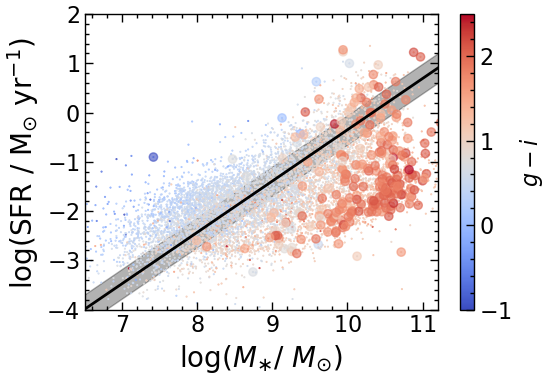

In [996]:
fig, ax = plt.subplots(1, 1, figsize=(5.7, 4.0))

x_eval = np.linspace(6, 12.5)
SFR_eval = -10.75 + 1.04*x_eval
plt.plot(x_eval, SFR_eval, color='k')
ax.fill_between(x_eval, SFR_eval+0.3, SFR_eval-0.3, alpha=0.3, color='k', zorder=-1)

mask = L_FUV_corr > 0
c = np.clip(data_50Mpc['gi_color'][mask], -1, 2.5)
im = ax.scatter(data_50Mpc['logmass'][mask], data_50Mpc['logSFR'][mask], marker='.', s=1, c=c, cmap='coolwarm')

mask_x = (data_50Mpc['_log_lx'] > 0) & (data_50Mpc['_log_lx_err']>0)
c = np.clip(data_50Mpc['gi_color'][mask & mask_x], -1, 2.5)
_ = ax.scatter(data_50Mpc['logmass'][mask & mask_x], data_50Mpc['logSFR'][mask & mask_x],
               marker='o', c=c, alpha=0.6, cmap='coolwarm', zorder=1)

#ax.scatter(data_50Mpc['logmass'][~mask], data_50Mpc['logSFR'][~mask], zorder=-1)

axc = fig.colorbar(im, ax=ax, cmap='RdBu')
axc.set_label(r'$g-i$')

ax.set_xlim(6.5, 11.2)
ax.set_ylim(-4, 2)

ax.set_ylabel(r'$\log( \rm{SFR}\ /\ M_{\odot}\ {\rm{yr}}^{-1} )$ ', fontsize=20)
ax.set_xlabel(r'$\log( M_{\ast} /\ M_{\odot})$', fontsize=20)

#ax.legend(fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('SFRMS.pdf', dpi=300)

## Completeness 

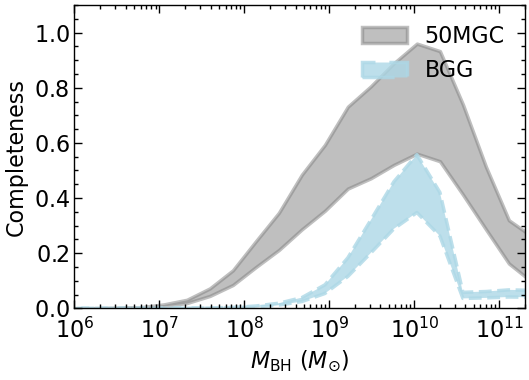

In [237]:
Ms = 10**10.745
phi1 = 10**-2.437
phi2 = 10**-3.201
alpha1 = -0.466
alpha2 = -1.530

_M = np.logspace(5, 11.5, 25)
dM = np.diff(_M)
M = _M[:-1] + dM/2
phidM = np.exp(-M/Ms)*(phi1*(M/Ms)**alpha1 + phi2*(M/Ms)**alpha2) * dM/Ms
#plt.loglog(M, phidM/np.diff(np.log10(_M)))
#plt.ylim(1e-5, 1e0)

# Draw from the GSMF
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

# Plot

#fig, ax0 = plt.subplots(1, 1, figsize=(6, 4.5))
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4.0))


# X-ray
V = 4/3*np.pi*(50)**3
N_draw = int(V*np.trapz(phidM))
completeness_50MGC = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)

    h, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, h, color='r', lw=2.5, label='model GSMF')

    # Exlude |b| < 30 deg
    mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

    # Exlude Virgo and Fornax
    mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
    mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

    mask = mask_b & mask_virgo & mask_fornax & (data_50Mpc['z_dr16'] < 0.12) & (data_50Mpc['z_gama'] < 0.12) #& (data_50Mpc['_log_lx'] > 0)
    h, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    #ax0.loglog(M, h, color='r', linestyle='dashed', lw=2.5, label='50MGC')

    # Completeness
    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    hist, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    completeness_50MGC[:,i] = hist/hist_model
    completeness_50MGC[~np.isfinite(hist/hist_model),i] = 10
    #ax1.semilogx(M, completeness_50MGC, color='r', label='50MGC', linestyle='dashed', lw=2.5)

ax1.fill_between(M, np.percentile(completeness_50MGC, 16, axis=1), np.percentile(completeness_50MGC, 84, axis=1),
                color='gray', label='50MGC', linestyle='solid', lw=2.5, alpha=0.5)

# AMUSE
V = 4/3*np.pi*(30)**3
N_draw = int(V*np.trapz(phidM))
completeness_30MGC = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)

    h, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, h, color='r', lw=2.5, label='model GSMF')

    # Completeness
    mask = mask_b & mask_virgo & mask_fornax & (data_50Mpc['z_dr16'] < 0.12) & (data_50Mpc['z_gama'] < 0.12) & (data_50Mpc['bestdist'] < 30)
    h, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    #ax0.loglog(M, h, color='r', linestyle='dashed', lw=2.5, label='30MGC')

    hist, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    completeness_30MGC[:,i] = hist/hist_model
    completeness_30MGC[~np.isfinite(hist/hist_model),i] = 10
    #ax1.plot(M, completeness_30MGC, color='gray', label='30MGC', linestyle='dashed', lw=2.5)

#ax1.fill_between(M, np.percentile(completeness_30MGC, 16, axis=1), np.percentile(completeness_30MGC, 84, axis=1),
#                 color='gray', label='30MGC', linestyle='solid', lw=2.5, alpha=0.5)


##########################

import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg = Table.from_pandas(data_bgg)
data_bgg['nsaid'] = np.array([s[3:] for s in data_bgg['ObjID']], dtype=int)
cat_bgg = SkyCoord(data_bgg['RA'], data_bgg['Dec'], unit=u.deg)

# Variability
omega = (9380*u.deg**2).to(u.sr)
V = (cosmo.comoving_volume(0.055)*omega/(4*np.pi)).value
N_draw = int(V*np.trapz(phidM))
completeness_BGG = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)
    # Add some scatter
    M_star = 10**(np.log10(M_star) + np.random.normal(0, 0.3, len(M_star)))

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, hist_model, color='b', lw=2.5, label='model GSMF')

    stellar_mass = data_bgg['Mstar']
    hist, bin_edges = np.histogram(stellar_mass, bins=_M)

    #ax0.loglog(M, hist, color='b', linestyle='dotted', lw=2.5, label='BGG')

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    completeness_BGG[:,i] = hist/hist_model
    completeness_BGG[~np.isfinite(hist/hist_model),i] = 10
    #ax1.semilogx(M, completeness_BGG, color='b', label='BGG', linestyle='dashed', lw=2.5)

ax1.fill_between(M, np.percentile(completeness_BGG, 16, axis=1), np.percentile(completeness_BGG, 84, axis=1),
                color='lightblue', label='BGG', linestyle='dashed', lw=2.5, alpha=0.8)

#####


ax1.set_xlim(1e6, 2e11)
ax1.set_ylim(0, 1.1)

ax1.set_xscale('log')


ax1.set_xlabel(r'$M_{\rm{BH}}$ ($M_{\odot}$)')
ax1.set_ylabel(r'Completeness')
ax1.legend(fontsize=16)

# Axis
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax1.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax1.tick_params(axis='x', which='major', pad=7)


fig.tight_layout()
fig.savefig('completeness.pdf', dpi=300)

## AMUSE

## Inference

In [238]:
dat_miller = ascii.read('miller15.txt', format='csv', delimiter='\t', names=['name', 'V/F', 'dist', 'method', 'logmstar', 'loglx', 'sample'])
dat_miller
coord_miller = concatenate([SkyCoord.from_name(s) for s in dat_miller['name']])

# Match to Miller
idx_result, idx_50Mpc, d2d, d3d = coord_miller.search_around_sky(cat_50Mpc, 20*u.arcsec)
print(len(coord_miller), len(idx_result))

197 195


In [239]:
os.environ["OMP_NUM_THREADS"] = "1"

#from multiprocessing import Pool
from multiprocess import Pool

from multiprocessing import cpu_count
ncpu = cpu_count() - 1
print("{0} CPUs".format(ncpu))

7 CPUs


In [240]:
dataset = 'field'
#dataset = 'M15'
#dataset = 'virgo'


[1. 1. 1. ... 1. 1. 1.]


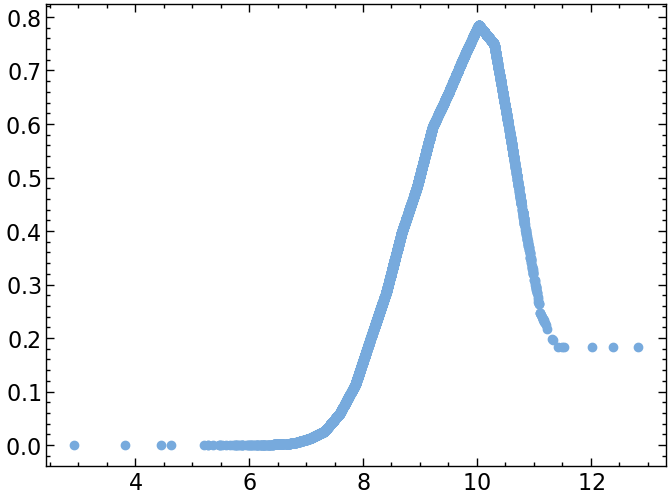

In [247]:
xp=10.0
yp=38.0

nsamp=4000
nburn=2000 

if dataset == 'M15':

    dat_amuse = ascii.read('miller15.txt', guess=False, format='csv', delimiter='\t')
    dat_amuse

    dat_amuse = dat_amuse[dat_amuse['note']=='Clean'] # clean sample
    # Remove sources

    # Read the table, if the luminosity is an upper limit, add a flag
    dat_amuse['flag_lim'] = 0
    for i, Lxi in enumerate(dat_amuse['logLx']):
        if '<' in Lxi:
            dat_amuse['logLx'][i] = Lxi[1:]
            dat_amuse['flag_lim'][i] = 1
    dat_amuse['logLx'] = np.array(dat_amuse['logLx'].data, dtype=float)

    x = dat_amuse['logMs'].data
    y = dat_amuse['logLx'].data


    # remove the outliers < 1e9

    xerr = np.full_like(y, 0.2)
    yerr = np.full_like(y, 0.1)
    yerr[dat_amuse['flag_lim']==1] = -1

    p_obs = np.clip(np.interp(x, np.log10(M), np.mean(completeness_50MGC, axis=1)), 1e-6, 1)

    logsfr = np.full_like(y, -20)
    logsfrerr = np.full_like(y, 0.1)

    # all early types
    n = np.full_like(y, 4.0)
    # Use size-mass relation
    d25 = 4 * 3.47*1e-5*(10**(x))**0.56 # 0.5 dex scatter
    d25 = d25 * cosmo.arcsec_per_kpc_proper(z_at_value(cosmo.comoving_distance, 15*u.Mpc)).value

else:

    _y = data_50Mpc['_log_lx'].copy()
    _yerr = data_50Mpc['_log_lx_err'].copy()

    # sources with no observation should have an upper limit set by ROSAT or EROSITA
    # Use whichever limit is more constraining
    #yerr[y==-1] = -1.0

    _x = data_50Mpc['logmass'].copy()
    _xerr = np.sqrt((data_50Mpc['logmass_error'].copy())**2 + 0.3**2)

    ## TODO: ADD these quantities to the full table and use ROSAT flux limit for the non-detections

    # Exlude |b| < 30 deg
    mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

    if dataset == 'virgo':

        mask_virgo = (cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) < 12*u.deg) & (np.abs(data_50Mpc['bestdist'] - 16.5) < 3*data_50Mpc['bestdist_error'])

    else:

        # Exlude Virgo and Fornax
        mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
        
    mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

    mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
        (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0)
    x = _x[mask]
    y = _y[mask]
    xerr = _xerr[mask]
    yerr = _yerr[mask]
    logsfr = data_50Mpc['logSFR'].copy()[mask]
    logsfrerr = data_50Mpc['logSFRerr'].copy()[mask]
    dist = data_50Mpc['bestdist'].copy()[mask]
    colortype = data_50Mpc['best_type'].copy()[mask]
    d25 = data_50Mpc['d25'].copy()[mask]*60 # arcsec
    mask_nod25 = ~np.isfinite(d25)
    # 2 R50 = R100
    # 2 R100 = d
    # Start with size-mass relation
    d25[mask_nod25 & (colortype=='early')] = 4 * 3.47*1e-5*(10**(x[mask_nod25 & (colortype=='early')]))**0.56 # 0.5 dex scatter
    d25[mask_nod25 & (colortype=='late')] = 4 * 0.1*(10**(x[mask_nod25 & (colortype=='late')]))**0.14 * (1 + 10**(x[mask_nod25 & (colortype=='late')])/(3.98*1e10))**(0.39 - 0.14) # 0.5 dex scatter
    d25[mask_nod25] = d25[mask_nod25] * cosmo.arcsec_per_kpc_proper(z_at_value(cosmo.comoving_distance, dist[mask_nod25]*u.Mpc)).value
    # Start with average value for galaxies without best type
    n = np.full(len(x), 2.5)
    n[colortype=='early'] = 4.0
    n[colortype=='late'] = 1.0
    print(n)

    lvlass = data_50Mpc['Ftot'].copy()[mask]
    lvlass_e = data_50Mpc['e_Ftot'].copy()[mask]

    # 2-7 keV -> 2-10 keV
    Gamma = 1.8
    Lb = (10**(2-Gamma) - 2**(2-Gamma))/(7**(2-Gamma) - 2**(2-Gamma))
    y_27 = y

    y = np.log10(Lb*10**y_27)
    yerr = y/y_27*yerr

    if (dataset == 'virgo') or (dataset == 'M15'):

        p_obs = np.ones_like(x)

    else:

        p_obs = np.clip(np.interp(x, np.log10(M), np.mean(completeness_50MGC, axis=1)), 1e-6, 1)

    #p_obs = np.ones_like(x)

    plt.scatter(x, p_obs)

    # Save the input for multiwavelength analysis!
    tvar = Table([x, y, xerr, yerr, logsfr, logsfrerr, d25, n, p_obs], names=['x', 'y', 'xerr', 'yerr', 'logsfr', 'logsfrerr', 'd25', 'n', 'pobs'])
    tvar.write('tcsc.txt', overwrite=True, format='ascii')

## INFERENCE

color='C4'
ylims=[None, None]

x = x-xp
y = y-yp

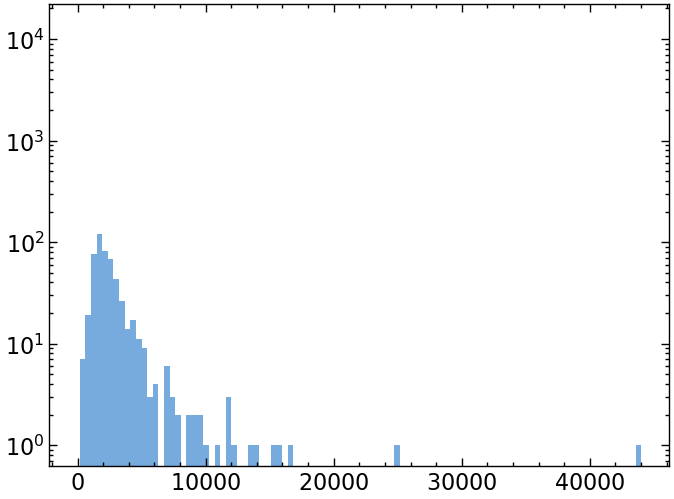

In [261]:
plt.hist(d25[mask_nod25]*60, log=True, bins=100)
plt.hist(data_50Mpc['d25'], log=True, bins=100, zorder=-1);

In [1003]:


#np.random.seed(424)
nll = lambda *args: -log_likelihood_init(*args)

initial = np.array([0.0, 0.5, np.log(0.2)])
initial += 1e-4 * np.random.randn(len(initial))
soln = minimize(nll, initial, args=(x, y, xerr, yerr))
alpha_ml, beta_ml, log_f_ml = soln.x

log_f_ml = -0.8

print("Maximum likelihood estimates:")
print("alpha = {0:.3f}".format(alpha_ml+yp))
print("beta = {0:.3f}".format(beta_ml))
print("sigma = {0:.3f}".format(np.exp(2*log_f_ml)))

#      logms0, alpha, beta,    log_f,  f_a, delta, theta
pos = [-2, soln.x[0], soln.x[1], -0.1, 0.98, 1, 1]

pos = np.array(pos) + 1e-4 * np.random.randn(32, len(pos))
nwalkers, ndim = pos.shape

# log probability global
args_global = (x, y, xerr, yerr, logsfr, logsfrerr, xp, yp, d25, n, p_obs)
def log_probability(theta):
    x, y, xerr, yerr, logSFR, logSFRerr, xp, yp, d25, n, p_obs = args_global
    lp = log_prior(theta)
    ll = log_likelihood(theta, x, y, xerr, yerr, logSFR, logSFRerr, xp, yp, d25, n, p_obs)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

Maximum likelihood estimates:
alpha = 38.871
beta = 2.057
sigma = 0.202


In [1004]:

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    sampler.run_mcmc(pos, nsamp, progress=True);


# Plot
fig, axes = plt.subplots(ndim, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()

labels = [r"$\log(M_{\star,0}/M_{\odot})$", r"$\alpha$", r"$\beta$", r"$\sigma$ [dex]", r'$f_a$', r'$a$', r'$\theta$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)

#flat_samples_amuse = sampler_amuse.get_chain(discard=nburn, thin=5, flat=True)

print(flat_samples.shape)

# Medians
alpha50 = np.median(flat_samples[:,1])
beta50 = np.median(flat_samples[:,2])
sigma50 = np.median(np.exp(2*flat_samples[:,3])) 

# Corner
flat_samples[:,3] = np.exp(2*flat_samples[:,3]) # sigma
flat_samples[:,0] += xp # log M_*,0
flat_samples[:,1] += yp # alpha
fig_corner = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.84], color=color, show_titles=True)


# TODO::::: Increase the 1st column limit + 1 and use 95th percentile

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
#inds = np.random.randint(len(flat_samples), size=100)

# Plot data
x_eval = np.linspace(-5, 5, 200)
axes[0].scatter(x[yerr > 0] + xp, y[yerr > 0] + yp, marker='.', color='k', alpha=1)
axes[0].errorbar(x[yerr > 0] + xp, y[yerr > 0] + yp, elinewidth=1,
                    xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                    fmt=".k", capsize=0, alpha=0.2, label='Chandra detections')
# Pick random

if len(y[yerr < 0]) > 50:
    ind_rand = np.random.choice(len(y[yerr < 0]), 50, replace=False)
else:
    ind_rand = np.arange(len(y[yerr < 0]))

axes[0].errorbar(x[yerr < 0][ind_rand] + xp, y[yerr < 0][ind_rand] + yp,
                    xerr=xerr[yerr < 0][ind_rand], elinewidth=1, markersize=5,
                    marker="v", linestyle="none", color="gray", alpha=0.4, capsize=0, zorder=-1, label='Chandra non-detections')
#axes[0].errorbar(x[(yerr < 0) & (y<40)] + xp, y[(yerr < 0) & (y<40)] + yp,
#                    xerr=xerr[(yerr < 0) & (y<40)], elinewidth=1,
#                    marker="v", linestyle="none", color="gray", alpha=0.5, capsize=0, zorder=-1)
axes[0].legend(fontsize=14)
axes[0].set_xlim([6.5, 12])
axes[0].set_ylim([35, 43])
axes[0].set_xlabel(r'$\log(M_{\star} / M_{\odot})$')
axes[0].set_ylabel(r'$\log(L_{2{-}10\ {\rm{keV}}} / {\rm{erg}}\ {\rm{s}}^{-1})$')

# Linear relation
relation = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    relation[i,:] = np.dot(np.vander(x_eval, 2), [s[2], s[1]])

axes[0].fill_between(x_eval + xp, np.percentile(relation, 84, axis=0), np.percentile(relation, 16, axis=0),
                        color=color, alpha=0.5, zorder=2, label=r'$L_{2{-}10\ {\rm{keV}}} - M_{\star}$ relation')
axes[0].plot(x_eval + xp, np.percentile(relation, 84, axis=0)+sigma50,
             color=color, alpha=0.8, zorder=2, linestyle='dotted')
axes[0].plot(x_eval + xp, np.percentile(relation, 16, axis=0)-sigma50,
            color=color, alpha=0.8, zorder=2, linestyle='dotted')

# Limits
log_ms0_low = np.percentile(flat_samples[:,0], 95)
log_ms0_high = np.percentile(flat_samples[:,0], 5)
print('95% CI: ', log_ms0_low)

# Occupation fraction
foccs = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    xii = np.exp(s[5])
    theta2i = s[6]
    foccs[i,:] = 1/(1 + xii * np.exp(-theta2i*(x_eval + xp - s[0])))**(1/xii)
    #foccs[i,:] = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - s[0]) * (x_eval + xp - s[0])))

#axes[1].plot(x_eval + xp, f_occ_low, color, alpha=0.1)
axes[1].fill_between(x_eval + xp, np.percentile(foccs, 16, axis=0),  np.percentile(foccs, 84, axis=0), color=color, alpha=0.3,
                        label=r'Joint $L_{2{-}10\ {\rm{keV}}} - M_{\star}$ relation &'+'\n'+'occupation fraction constraint')

if dataset == 'virgo':
    # Overplot the field results in gray

    flat_samples_field = np.load('flat_samples_xray.npy')

    # Occupation fraction
    foccs = np.zeros([len(flat_samples_field), len(x_eval)])
    for i, s in enumerate(flat_samples_field):
        xii = np.exp(s[5])
        theta2i = s[6]
        foccs[i,:] = 1/(1 + xii * np.exp(-theta2i*(x_eval + xp - s[0])))**(1/xii)

    axes[1].fill_between(x_eval + xp, np.percentile(foccs, 16, axis=0),  np.percentile(foccs, 84, axis=0), color='gray', alpha=0.1,
                        label=r'field galaxies')


elif dataset == 'M15':
    axes[1].fill_between(x_eval+xp, 0.5 + 0.5*np.tanh(2.5**np.abs(8.9 - 7.70) * (x_eval + xp - 7.70)),
                     0.5 + 0.5*np.tanh(2.5**np.abs(8.9 - 9.18) * (x_eval + xp - 9.18)), color='gray', alpha=0.1, label='M15')


# Emitting fraction
axes[1].plot(x_eval + xp, 10*f_X(x_eval, -5),
             color=color, alpha=1, linestyle='dashed')
#print(scale_hist*f_var(x_eval, beta_x50, -5, xi50, l050 - yp))

# Histogram
hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(-3, 3, 0.5))
hist_all, bin_edges = np.histogram(x,  bins=np.arange(-3, 3, 0.5))
frac_det = hist_det/hist_all

bincenter = (bin_edges[:-1] + bin_edges[1:]) / 2

axes[1].errorbar(bincenter[hist_det>0] + xp, frac_det[hist_det>0],
                    yerr=st.binom.std(hist_all[hist_det>0], frac_det[hist_det>0])/hist_all[hist_det>0],
                    color="k", capsize=0, label='Chandra detection fraction')

# Expectation fraction
fexp = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    alphai = flat_samples[i,1]
    betai = flat_samples[i,2]
    si = flat_samples[i,3]
    fa50 = flat_samples[i,4]
    y_lim = np.median(y[(yerr<0) & (x+xp>10)]) + yp
    fexp[i,:] = fa50 * foccs[i,:] * st.norm.sf(y_lim, alphai + betai*(x_eval), si)

axes[1].plot(x_eval+xp, np.percentile(fexp, 50, axis=0), color=color, lw=4, label=r'Expected detection fraction')

axes[1].set_xlim([6.5, 12])
axes[1].set_ylim([-0.05, 1])
axes[1].set_xlabel(r"$\log(M_{\star} / M_{\odot})$")
axes[1].set_ylabel(r"Occupation Fraction")

axes[0].legend(loc='upper left', fontsize=9, frameon=True)
if dataset == 'virgo':
    axes[1].legend(loc='upper right', fontsize=9, frameon=True)
else:
    axes[1].legend(loc='upper left', fontsize=9, frameon=True)

fig_corner.text(.8, .8, 'X-ray: \n'+r'$M_{\star,0} < $'+f'{np.round(log_ms0_low,2)}'+r' $M_{\odot}$', ha='center', fontsize=26)

#axes[0].plot(x_eval+xp, np.log10(9.05*1e28 * 10**(x_eval+xp)) + 0.4, color='k')
#axes[0].plot(x_eval+xp, np.log10(9.05*1e28 * 10**(x_eval+xp)), color='k')

print(y_lim)
fig.tight_layout()

#fig_corner.savefig('corner_csc.pdf', dpi=300)

if dataset == 'virgo':
    fig.savefig('bhofxrayvirgo.pdf', dpi=300)
elif dataset == 'M15':
    fig.savefig('bhofxraymiller.pdf', dpi=300)
else:
    fig.savefig('bhofxray.pdf', dpi=300)

  4%|▍         | 166/4000 [04:14<1:37:56,  1.53s/it]


KeyboardInterrupt: 

In [ ]:
if dataset == 'field':
    np.save('flat_samples_xray', flat_samples)

In [194]:
dataset = 'field'
if dataset == 'field':
    flat_samples = np.load('flat_samples_xray.npy')

(array([ 4.,  8.,  6., 10.,  4.,  1.,  0.,  1.,  0.,  1.]),
 array([37.58108973, 37.92170685, 38.26232397, 38.60294108, 38.9435582 ,
        39.28417531, 39.62479243, 39.96540954, 40.30602666, 40.64664378,
        40.98726089]),
 <BarContainer object of 10 artists>)

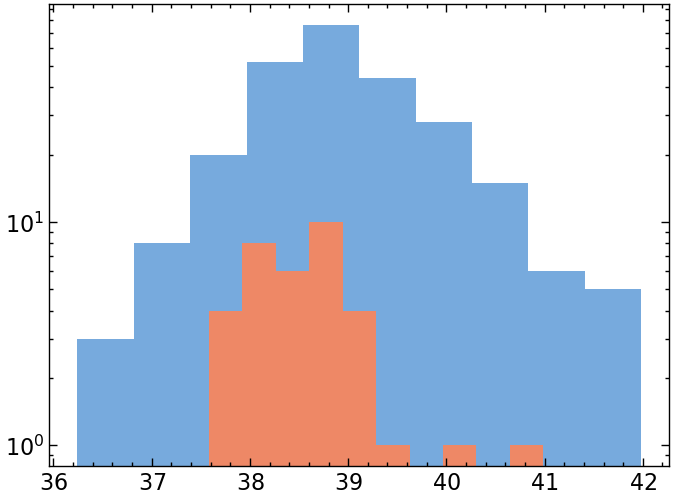

In [ ]:
plt.hist(_y[np.isfinite(_y) & (_yerr>0)], log=True)

mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
    (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0)
plt.hist(_y[mask & (_yerr>0)], log=True)


In [ ]:
mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
    (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0)

# Only include detections 

cols = ['objname', 'ra', 'dec', 'bestdist', 'bestdist_error', 'logmass', 'logmass_error', '_log_lx', '_log_lx_err', 'logSFR', 'logSFRerr', 'best_type']
# Write to latex
#data_50Mpc[mask][(y>0) & (yerr>0) & (x<8)]
data_50Mpc_out = data_50Mpc[mask][(yerr>0)]
data_50Mpc_out['_log_lx'] = np.round(data_50Mpc_out['_log_lx'], 2)
data_50Mpc_out['_log_lx_err'] = np.round(data_50Mpc_out['_log_lx_err'], 2)
data_50Mpc_out['logSFR'] = np.round(data_50Mpc_out['logSFR'], 2)
data_50Mpc_out['logSFRerr'] = np.round(data_50Mpc_out['logSFRerr'], 2)
data_50Mpc_out.write('xraytable.mrt', format='mrt', overwrite=True, include_names=cols)
data_50Mpc_out['ra'] = np.round(data_50Mpc_out['ra'], 4)
data_50Mpc_out['dec'] = np.round(data_50Mpc_out['dec'], 4)
data_50Mpc_out.write('xraytable.tab', format='latex', overwrite=True, include_names=cols)

# Write to mrt

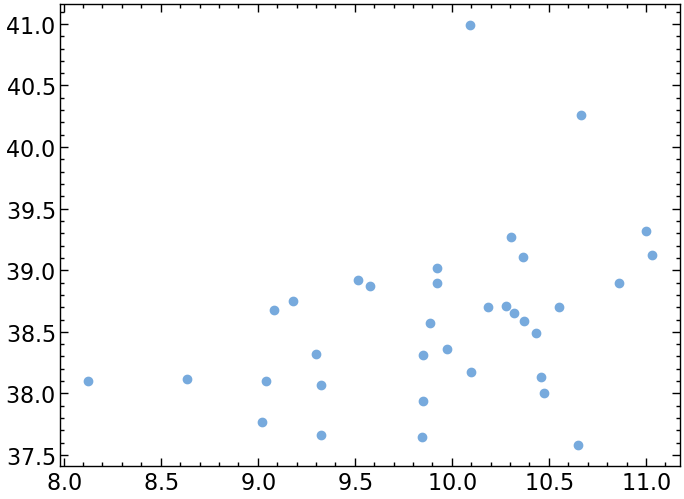

In [ ]:
plt.scatter(data_50Mpc_out['logmass'], data_50Mpc_out['_log_lx'])

In [ ]:
data_50Mpc[mask][(yerr>0) & ((x+xp)<8 )]

objname,pgc,nsaid,group_id,ra,dec,ra_nsa,dec_nsa,ra_ned,dec_ned,d25,v_h,v_cmb,v_source,hl_obj,lvg_obj,nsa_obj,sga_obj,t_type,color_type,best_type,a_B_leda,a_g_nsa,EBV_irsa,Bt0_leda,BV_color_leda,B_lum,gi_color_nsa,i_lum_nsa,gr_color_sga,r_lum_sga,BR_color_ned,R_lum_ned,BMag,gi_color,mag_flag,cf3_dist,cf3_dist_error,zind_dist,zind_dist_error,zind_indicator,bestdist,bestdist_error,bestdist_method,bestdist_source,dist_ned_flag,logmass_gi,logmass_gr,logmass_BV,logmass_BR,logmass,logmass_error,logmass_src,chandra_observation,chandra_detection,log_lx,chandra_detection_3arcsec,log_lx_3arcsec,log_lx_csc,log_lx_err_csc,log_lx_sens,log_lx_xmm,log_lx_err_xmm,log_lx_erosita,log_lx_err_erosita,log_lx_rosat,log_lx_err_rosat,_log_lx,_log_lx_err,z_dr16,z_gama,Ftot,e_Ftot,log_l_vlass,l_vlass_err,NUV,FUV,W4mag,logSFR,logSFRerr
str29,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,str3,float64,float64,float64,float64,float64,str6,str6,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str32,float64,float64,str32,int32,int32,float64,float64,float64,float64,float64,float64,str64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [ ]:
np.min(y+yp)

36.73721402235293

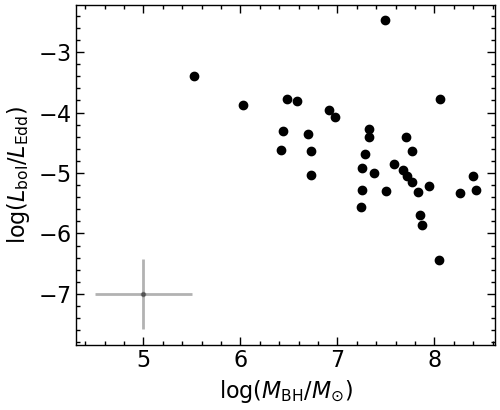

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.3))

#ax.scatter(x[yerr>0]+xp, y[yerr>0]+yp)

sBHAR = 1 + (1 + y[yerr>0]+yp) - np.log10(1.26*1e38 * .0025*10**(x[yerr>0]+xp))

ax.legend()

ax.plot(np.log10(.0025*10**(x[yerr>0]+xp)), sBHAR, marker='o', linestyle='none', color='k')

sx = 0.5
sy = np.sqrt(0.3**2 + 0.5**2)

ax.errorbar(5, -7, xerr=sx, yerr=sy, color='k', alpha=0.3, marker='.')

ax.set_xlabel(r'$\log( M_{\rm{BH}}/M_{\odot} )$')
ax.set_ylabel(r'$\log(L_{\rm{bol}}/L_{\rm{Edd}})$')
fig.tight_layout()
fig.savefig('erdfmass.pdf', dpi=300)

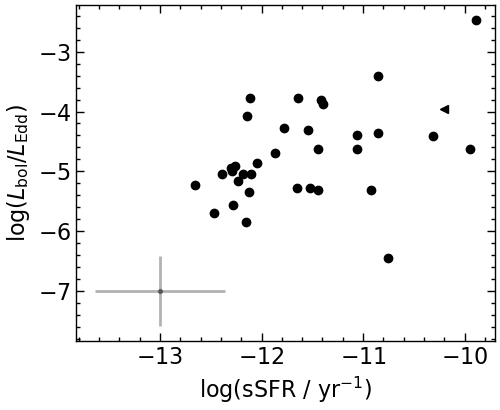

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.3))

#ax.scatter(x[yerr>0]+xp, y[yerr>0]+yp)

lambdaEdd = 1 + (1 + y+yp) - np.log10(1.26*1e38 * .0025*10**(x+xp))
#sBHAR = lambdaEdd/(.0025*10**(x[yerr>0]+xp))

sSFR = logsfr - ((x+xp))

ax.legend()

sx = np.sqrt(0.4**2 + 0.5**2)
sy = np.sqrt(0.3**2 + 0.5**2)

ax.errorbar(-13, -7, xerr=sx, yerr=sy, color='k', alpha=0.3, marker='.')

masksfr = (yerr>0) & (logsfrerr == 0.3)
ax.plot(sSFR[masksfr], lambdaEdd[masksfr], marker='o', linestyle='none', color='k')
masksfr = (yerr>0) & (logsfrerr > 0.3)
ax.plot(sSFR[masksfr], lambdaEdd[masksfr], marker='<', linestyle='none', color='k')

ax.set_xlabel(r'$\log( {\rm sSFR}\ /\ {\rm yr}^{-1} )$')
ax.set_ylabel(r'$\log( L_{\rm{bol}}/L_{\rm{Edd}} )$')
fig.tight_layout()
fig.savefig('erdfsfr.pdf', dpi=300)

In [197]:
def logGSMF_blue(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)
    return phi

def logGSMF_red(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 red galaxy population (double Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi1 = 3.25*1e-3
    phi2 = 0.08*1e-3
    alpha1 = -0.45
    alpha2 = -1.45
    phi_red = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))

    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi_blue = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)

    ratio = phi_red / (phi_red + phi_blue)
    
    return phi_red

In [198]:
def logGSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    # dN/dlogM
    phi = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))
    
    return phi

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31573/3849495983.py:29: RuntimeWarning: invalid value encountered in divide
  ratio = phi_red / (phi_red + phi_blue)
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31573/3491097706.py:116: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/Users/colinburke/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


NameError: name 'fig2' is not defined

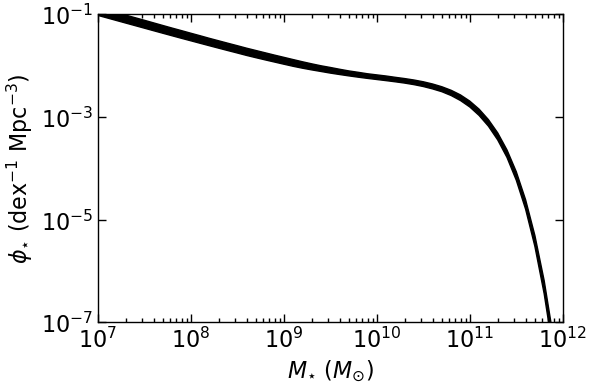

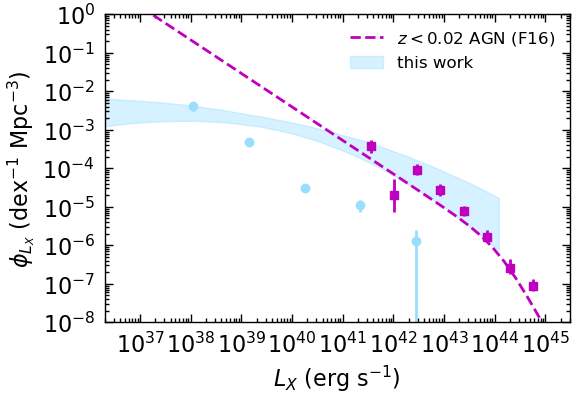

In [244]:
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 4.0))
ax1.set_xscale('log')
ax1.set_yscale('log')

fig3, ax3 = plt.subplots(1, 1, figsize=(6, 4.0))
ax3.set_xscale('log')
ax3.set_yscale('log')

#TODO: Check bin center

# grid
dlogm = .1
logms = np.arange(2.0, 20.5, dlogm)
ms = 10**logms
dms = np.diff(ms)

Nsamp = 200
#Nsamp = len(flat_samples)

gsmf = np.zeros([len(logms), Nsamp])
gsmf_blue = np.zeros([len(logms), Nsamp])
gsmf_red = np.zeros([len(logms), Nsamp])

bhmf1_blue = np.zeros([len(logms), Nsamp])
bhmf1_red = np.zeros([len(logms), Nsamp])

# BHOF should not depend on galaxy color type
bhmf_xray = np.zeros([len(logms), Nsamp])
bhmf_xray_blue = np.zeros([len(logms), Nsamp])
bhmf_xray_red = np.zeros([len(logms), Nsamp])

bhmf_radio = np.zeros([len(logms), Nsamp])
bhmf_radio_blue = np.zeros([len(logms), Nsamp])
bhmf_radio_red = np.zeros([len(logms), Nsamp])

bhmf_optical = np.zeros([len(logms), Nsamp])
bhmf_optical_blue = np.zeros([len(logms), Nsamp])
bhmf_optical_red = np.zeros([len(logms), Nsamp])

bhlf = np.zeros([len(logms), Nsamp])

focc_radio = np.load('focc_vlass.npy')
focc_optical = np.load('focc_ptf.npy')

for i in range(Nsamp):

    # total BH mass function is dominated by early population
    # GSH20, early-type / E, limits
    alpha_red = np.random.normal(7.89, 0.09, size=1)
    beta_red = np.random.normal(1.33, 0.12, size=1)
    sigma_red = np.random.normal(0.65, 0.05, size=1)
    logms0_red = np.log10(3*1e10)

    # grid
    logmb_red = alpha_red + beta_red*(logms - logms0_red)
    mb_red = 10**logmb_red
    dmb_red = np.diff(mb_red)

    # BH mass - stellar mass relation
    # RV15 / similar to GSH20, early-type
    alpha_blue = np.random.normal(7.45, 0.08, size=1)
    beta_blue = np.random.normal(1.05, 0.11, size=1)
    sigma_blue = np.random.normal(0.55-0.3, 0.02, size=1) # Assume 10% error on scatter
    logms0_blue = 11

    #alpha_blue = np.random.normal(6.70, 0.13, size=1)
    #beta_blue = np.random.normal(1.61, 0.24, size=1)
    #sigma_blue = np.random.normal(0.65, 0.09, size=1) # Assume 10% error on scatter
    #logms0_blue = np.log10(3*1e10)

    # grid
    logmb_blue = alpha_blue + beta_blue*(logms - logms0_blue)
    mb_blue = 10**logmb_blue
    dmb_blue = np.diff(mb_blue)

    # LX - Ms relation
    alpha_l = flat_samples[i,1] #+ 1 
    beta_l = flat_samples[i,2]
    sigma_l = flat_samples[i,3] + 1
    fa = flat_samples[i,4]
    logms0_l = np.log10(3*1e10)
    
    logl = alpha_l + beta_l*(logms - 10)
    l = 10**logl
    dl = np.diff(l)
    dlogl = np.diff(logl)[0]

    gsmf[:,i] = logGSMF(ms)
    gsmf_blue[:,i] = logGSMF_blue(ms)
    gsmf_red[:,i] = logGSMF_red(ms)

    # Convolve
    xii = np.exp(flat_samples[i,5])
    theta2i = flat_samples[i,6]
    x50i = flat_samples[i,0]
    focci_xray = 1/(1 + xii * np.exp(-theta2i*(logms - x50i)))**(1/xii)

    # Convolve
    #fa = 1 # doesnt help that much
    # increasing scatter would help
    
    bhlf[:,i] = np.array([np.trapz(fa * focci_xray * gsmf[:,i] * st.norm.pdf(logli-logms, loc=logl-logms, scale=sigma_l)*dlogm) for logli in logl])
    # int per dex * dex PDF = per dex
    # # PDF units are in per dex! ##


# gsfm

# Plot
ax1.fill_between(ms[:-1], np.percentile(gsmf[:-1], 16, axis=1),
           np.percentile(gsmf[:-1], 84, axis=1), color='k')
ax1.set_ylim(1e-7, 1e-1)
ax1.set_xlim(1e7, 1e12)
ax1.set_xlabel(r'$M_{\star}\ (M_{\odot})$')
ax1.set_ylabel(r'$\phi_{\star}$ (dex$^{-1}$ Mpc$^{-3})$')
fig1.show()

#########################################

Gamma = 1.8

gamma1 = 0.87
gamma2 = 2.40
A = 10**-5.97
L0 = 10**43.77
L = np.logspace(36, 47)
# # https://www.aanda.org/articles/aa/pdf/2016/03/aa24763-14.pdf
ax3.plot(L*(10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma)), A/((L/L0)**(gamma1) + (L/L0)**gamma2),
        color='m', linestyle='dashed', label='$z<0.02$ AGN (F16)')

#f_cont = ascii.read('fotopoulou_cont.dat')
#Lb = (10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma))*10**f_cont[:20]['col1'] # 0.5-7
#ax3.fill_between(Lb, 10**f_cont[:20]['col2'], 10**np.interp(f_cont[:20]['col1'], f_cont[20:]['col1'], f_cont[20:]['col2']),
#        color='m', label=r'$0.01<z<0.2$ AGN (F16)', alpha=0.4, lw=0)

dat = ascii.read('fotopoulou_dat.txt')
dat_hi = ascii.read('fotopoulou_hi.txt')
dat_lo = ascii.read('fotopoulou_lo.txt')

Lb = (10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma)) * 10**dat['col1'].data # 0.5-7
#Lb = 1 * 10**dat['col1'].data # 0.5-7

errs = np.array([10**dat['col2'] - 10**dat_lo['col2'], 10**dat_hi['col2'] - 10**dat['col2']])
ax3.errorbar(Lb, 10**dat['col2'], yerr=errs, linestyle='none', marker='s', color='m')

##### 1/Vmax #####
#L_HX = 9.05*1e28 * 10**(x+xp) + 1.62*1e39 * 10**logsfr
#loglx_lehmer = np.log10(L_HX)

#loglx_lehmer = np.zeros_like(logsfr)
#mask = 10**logsfr < 0.4
#loglx_lehmer = 39.57 + 0.94*logsfr
#loglx_lehmer[~mask] = 39.49 + 0.74*logsfr[~mask]
#mask = (loglx_lehmer + 0*0.4) < (y + yp) # 3 sigma

log_l_eval = np.linspace(30, 39.5)
l_eval = 10**log_l_eval
sens_lim = 10**np.nanmedian(np.log10(csc_results_sens['flux_sens_b'])[np.log10(csc_results_sens['flux_sens_b'])<30])

d = np.sqrt(l_eval / (sens_lim * 4*np.pi))
d = (d*u.cm).to(u.Mpc).value
Vmax = 4/3*np.pi*d**3

def invVmax_l(logl):
        return np.interp(logl, log_l_eval, 1/Vmax)

bins = np.linspace(37.5, 43, 6)
n, bins = np.histogram((y+yp)[(yerr > 0)], weights=invVmax_l(y+yp)[(yerr > 0)]/p_obs[(yerr > 0)], bins=bins)
err, bins = np.histogram((y+yp)[(yerr > 0)], weights=(invVmax_l(y+yp)[(yerr > 0)]/p_obs[(yerr > 0)])**2, bins=bins)
bin_width = (bins[:-1] + bins[1:])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_widths = 2.303*np.diff(bins) * 10**bin_centers
#xerr = np.array([10**bin_centers - 10**bin_width, 10**bin_centers - 10**bin_width])

ax3.errorbar(10**bin_centers, n, xerr=np.diff(bins), yerr=np.sqrt(err), linestyle='none', marker='o', color=color)

############################################################

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax3.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax3.yaxis.set_minor_locator(locmin)
ax3.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax3.tick_params(axis='y', which='major', pad=7)

dlogl = 1
ax3.fill_between(l[:-1], np.percentile(bhlf[:-1], 16, axis=1) * dlogl,
           np.percentile(bhlf[:-1], 84, axis=1) * dlogl, color=color, alpha=0.4, label='this work')
#ax3.set_xlim(1e37, 1e48)
ax3.set_xlim(2e36, 3e45)
ax3.set_ylim(1e-8, 1e0)
ax3.set_xlabel(r'$L_{X}$ (erg s$^{-1}$)')
ax3.set_ylabel(r'$\phi_{L_X}$ (dex$^{-1}$ Mpc$^{-3})$')
ax3.legend(fontsize=12)

# Axis
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax3.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax3.xaxis.set_minor_locator(locmin)
ax3.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax3.tick_params(axis='x', which='major', pad=7)

fig3.savefig('lfxray.pdf', dpi=300)
fig2.savefig('bhmf.pdf', dpi=300)

In [ ]:
flat_samples[i,3]

0.7258468864667129

In [ ]:
10**np.nanmedian(np.log10(csc_results_sens['flux_sens_b'])[np.log10(csc_results_sens['flux_sens_b'])<30]) * 4 * np.pi * ((5*u.Mpc).to(u.cm).value)**2

/Users/colinburke/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


1.2862849673663137e+37

### Fundamental Plane

In [ ]:
dat_fp = ascii.read('gultiken.txt', format='tab', guess=False)
dat_fp

Source,Dist.,References,M_BH,References_1,MJD,nu,S_nu,References_2,alpha_R,References_3,MJD_1,F_X,References_4,Notes,col15
str13,float64,int64,str40,int64,str5,str6,str19,str5,str15,str5,int64,str43,str5,str6,int64
MGC-02-36-002,152.4,1,${3.74}_{-0.52}^{+0.42}\times {10}^{9}$,2,44239,5,440.00 +or- 0.00,3,cdots,cdots,55342,${7.14}_{-1.19}^{+1.93}\times {10}^{-14}$,4,"^a^,^b",--
IC 4296,49.2,1,${1.30}_{-0.19}^{+0.20}\times {10}^{9}$,2,53280,8.46,247.70 +or- 1.70,5,0.10 +or- 0.24,6,52258,${5.85}_{-0.70}^{+0.46}\times {10}^{-13}$,7,cdots,--
Circinus,2.82,1,1.14 +or- 0.20 x 10^6,8,53907,4.8,304.00 +or- 15.00,9,1.13 +or- 0.11,10,51617,${1.61}_{-0.19}^{+0.05}\times {10}^{-10}$,7,"^c^,^b",--
Cygnus A,242.7,1,${2.66}_{-0.75}^{+0.74}\times {10}^{9}$,11,50249,5,160.00 +or- 10.00,12,cdots,cdots,51690,${2.21}_{-0.67}^{+0.11}\times {10}^{-11}$,7,"^a^,^c",--
Galaxy,0.00828,1,4.30 +or- 0.36 x 10^6,13,48182,5,710.00 +or- 72.00,14,1.00 +or- 0.10,14,51843,${2.87}_{-0.39}^{+0.53}\times {10}^{-13}$,15,cdots,--
Galaxy,0.00828,1,4.30 +or- 0.36 x 10^6,13,48182,5,710.00 +or- 72.00,14,1.00 +or- 0.10,14,51843,1.31 +or- 0.13 x 10^-11,15,cdots,--
Galaxy,0.00828,1,4.30 +or- 0.36 x 10^6,13,48182,5,710.00 +or- 72.00,14,1.00 +or- 0.10,14,55966,${2.51}_{-0.49}^{+0.94}\times {10}^{-11}$,16,cdots,--
IC 1459,28.92,1,${2.48}_{-0.19}^{+0.48}\times {10}^{9}$,17,52301,4.86,1125.70 +or- 1.10,5,0.21 +or- 0.02,18,52133,${6.45}_{-0.21}^{+0.19}\times {10}^{-13}$,7,cdots,--
IC 1481,89.9,1,${1.49}_{-0.45}^{+0.44}\times {10}^{7}$,19,51160,4.994,1.29 +or- 0.15,20,3.83 +or- 0.24,21,52133,cdots,cdots,^a,--


In [ ]:
fx = [si.split('_')[0].replace('${','').replace('}','')[:4] for si in dat_fp['F_X']]
t = [(fxi, i) for (i, fxi) in enumerate(fx) if not fxi.startswith('<') and not fxi.startswith('cdot')]
fx = np.array([ti[0] for ti in t], dtype=float)
mask_x = np.array([ti[1] for ti in t])

fxexp = [si.split('^')[-1].replace('{','').replace('}$','') for si in dat_fp['F_X']]
fxexp = np.array(fxexp)[mask_x].astype(int)

fx = fx*10.**fxexp


dist = dat_fp['Dist.'][mask_x]
F2L = 4*np.pi*(dist*u.Mpc)**2

fx = (fx*u.erg/u.s/u.cm**2 * F2L).to(u.erg/u.s).value

fxs = np.zeros(len(dat_fp))
fxs[mask_x] = fx

In [ ]:
fr = [si.split('_')[0].replace('${','').replace('}','')[:4] for si in dat_fp['S_nu']]
t = [(fri, i) for (i, fri) in enumerate(fr) if not fri.startswith('<') and not fri.startswith('cdot')]
fr = np.array([ti[0] for ti in t], dtype=float)
mask_r = np.array([ti[1] for ti in t])

dist = dat_fp['Dist.'][mask_r]
F2L = 4*np.pi*(dist*u.Mpc)**2

nu = np.array(dat_fp['nu'][mask_r], dtype=float)*u.GHz

fr = (fr*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(nu)).value

frs = np.zeros(len(dat_fp))
frs[mask_r] = fr

In [ ]:
m = [si.split('_')[0].replace('${','').replace('}','')[:4] for si in dat_fp['M_BH']]
t = [(mi, i) for (i, mi) in enumerate(m) if not mi.startswith('<') and not mi.startswith('cdot')]
m = np.array([ti[0] for ti in t], dtype=float)
mask_m = np.array([ti[1] for ti in t])

mexp = [si.split('^')[-1].replace('{','').replace('}$','') for si in dat_fp['M_BH']]
mexp = np.array(mexp)[mask_m].astype(int)

m = m*10**mexp

ms = np.zeros(len(dat_fp))
ms[mask_m] = m

/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31241/2726803966.py:3: RuntimeWarning: divide by zero encountered in log10
  log_l_vlass = np.log10((10**data_50Mpc['log_l_vlass']*u.mJy*u.cm**2).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value)
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31241/2726803966.py:4: RuntimeWarning: invalid value encountered in divide
  dlog_l_vlass = data_50Mpc['l_vlass_err']/(10**data_50Mpc['log_l_vlass']) * 10**log_l_vlass
/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_31241/2726803966.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(0.60*np.log10(fxs) + 0.78*np.log10(ms) + 7.33, np.log10(frs),


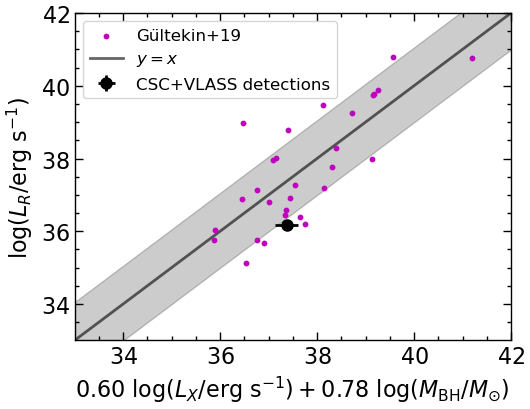

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.3))

log_l_vlass = np.log10((10**data_50Mpc['log_l_vlass']*u.mJy*u.cm**2).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value)
dlog_l_vlass = data_50Mpc['l_vlass_err']/(10**data_50Mpc['log_l_vlass']) * 10**log_l_vlass
dlog_l_vlass = 0.434 * dlog_l_vlass / 10**log_l_vlass

mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
    (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0) & (data_50Mpc['l_vlass_err'] > 0) & (data_50Mpc['_log_lx_err'] > 0)
#mask = (data_50Mpc['log_l_vlass_err'] > 0) & (data_50Mpc['_log_lx_err'] > 0)
logM = np.log10(0.0025*10**data_50Mpc['logmass'][mask])

ax.scatter(0.60*np.log10(fxs) + 0.78*np.log10(ms) + 7.33, np.log10(frs),
           color='m', label=r'Gültekin+19', marker='o', s=10, zorder=40)

ax.errorbar(0.60*data_50Mpc['_log_lx'][mask] + 0.78*logM + 7.33, log_l_vlass[mask], linestyle='none', marker='o',
           color='k', label=r'CSC+VLASS detections', markersize=8, xerr=np.sqrt((0.60*data_50Mpc['_log_lx_err'][mask])**2 + (0.78*0.3)**2),
           yerr=dlog_l_vlass[mask])

xx = np.linspace(32, 43)
ax.plot(xx, xx, color='k', label=r'$y=x$', alpha=0.6)
s = np.sqrt(.9**2 + 0.5**2)
ax.fill_between(xx, xx-s, xx+s, color='k', alpha=0.2)

#data_50Mpc['logmass'][mask
# These are very low L_bol/L_Edd < 1e-5 

ax.legend(fontsize=12, frameon=True)

ax.set_xlabel(r'$0.60\ \log (L_X/ {\rm{erg}}\ {\rm{s}}^{-1} ) + 0.78\ \log(M_{\rm{BH}}/M_{\odot})$')
ax.set_ylabel(r'$\log( L_R / $erg s$^{-1}$)')

ax.set_xlim(33, 42)
ax.set_ylim(33, 42)

fig.tight_layout()
fig.savefig('fp.pdf', dpi=300)

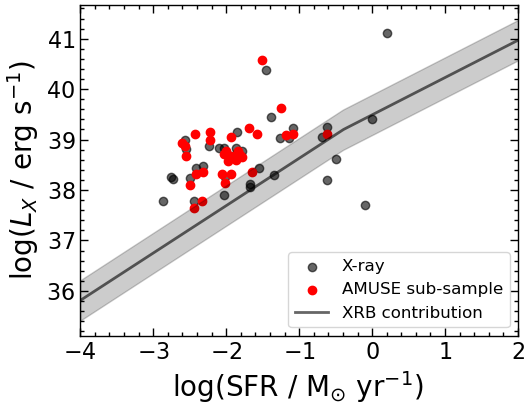

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.3))

ax.scatter(logsfr[yerr>0], y[yerr>0]+yp, color='k', alpha=0.6, label='X-ray')

mask = data_50Mpc['_log_lx_err'][idx_result]>0
ax.scatter(data_50Mpc['logSFR'][idx_result][mask], data_50Mpc['_log_lx'][idx_result][mask], color='r', label='AMUSE sub-sample')

logsfr_eval = np.linspace(-4, 2, 1000)
mask = 10**logsfr_eval < 0.4

lehmer = 39.57 + 0.94*logsfr_eval
lehmer[~mask] = 39.49 + 0.74*logsfr_eval[~mask]

ax.fill_between(logsfr_eval, lehmer - 0.4, lehmer + 0.4, alpha=0.2, color='k')
ax.plot(logsfr_eval, lehmer, alpha=0.6, color='k', label=r'XRB contribution')

#plt.fill_between(logsfr_eval[~mask], 39.49 + 0.74*logsfr_eval[~mask] - 0.4, 39.49 + 0.74*logsfr_eval[~mask] + 0.4, alpha=0.2, color='k')

#plt.fill_between(logsfr_eval, 39.57 + 0.94*logsfr_eval - 3*0.4, 39.57 + 0.94*logsfr_eval + 3*0.4, alpha=0.2, lw=2, linestyle='dotted')
ax.set_xlim(-4, 2)
ax.set_xlabel(r'$\log( \rm{SFR}\ /\ M_{\odot}\ {\rm{yr}}^{-1} )$ ', fontsize=20)
ax.set_ylabel(r'$\log( L_X\ /\ {\rm{erg}}\ {\rm{s}}^{-1})$', fontsize=20)

ax.legend(fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('LSFR.pdf', dpi=300)

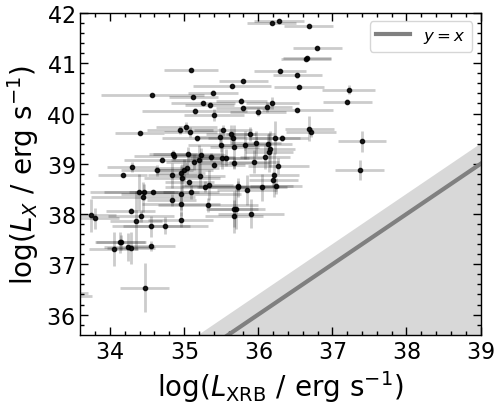

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.3))

#ax.scatter(logsfr[yerr>0], y[yerr>0]+yp, color='k', alpha=0.6, label='X-ray')

lehmer = np.log10( 9.05*1e28* 10**(x[yerr>0] + xp) + 1.62*1e39  *10**logsfr[yerr>0] ) #[mask]
#lehmer[~mask] = 39.49 + 0.74*logsfr_eval[~mask]

b = 2*n - 1/3
#lehmer += np.log10(gammainc(2*n[yerr>0], b*(1/60)**1/n[yerr>0])/gamma(2*n[yerr>0]))

lehmer += np.log10(gammainc(2*n, b*(r_match.to(u.arcsec).value/(d25/2))**1/n)/gamma(2*n))[yerr>0]

#ax.fill_between(logsfr_eval, lehmer - 0.4, lehmer + 0.4, alpha=0.2, color='k')
ax.errorbar(lehmer, y[yerr>0]+yp, yerr=yerr[yerr>0], xerr=xerr[yerr>0], 
            linestyle='none', marker='.',alpha=0.2, color='k')
ax.errorbar(lehmer, y[yerr>0]+yp, 
            linestyle='none', marker='.',alpha=0.8, color='k')

#mask = data_50Mpc['_log_lx_err'][idx_result]>0
#lehmer = np.log10( 9.05*1e28* 10**(x[(yerr>0) & mask] + xp) + 1.62*1e39  *10**logsfr[(yerr>0) & mask] )

#ax.errorbar(lehmer[mask], y[(yerr>0) & mask]+yp, 
#            linestyle='none', marker='.',alpha=0.8, color='k')

#plt.fill_between(logsfr_eval[~mask], 39.49 + 0.74*logsfr_eval[~mask] - 0.4, 39.49 + 0.74*logsfr_eval[~mask] + 0.4, alpha=0.2, color='k')

#plt.fill_between(logsfr_eval, 39.57 + 0.94*logsfr_eval - 3*0.4, 39.57 + 0.94*logsfr_eval + 3*0.4, alpha=0.2, lw=2, linestyle='dotted')
#ax.set_xlim(-4, 2)

xx = np.linspace(35, 42)
ax.plot(xx, xx, color='gray', lw=3, label=r'$y=x$')
ax.fill_between(xx, xx+0.4, xx- 100, color='gray', lw=0, alpha=0.3)

ax.set_xlim(33.6, 39)
ax.set_ylim(35.6, 42)

ax.set_xlabel(r'$\log( L_{\rm XRB}\ /\ {\rm{erg}}\ {\rm{s}}^{-1})$', fontsize=20)
ax.set_ylabel(r'$\log( L_X\ /\ {\rm{erg}}\ {\rm{s}}^{-1})$', fontsize=20)

ax.legend(fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('LSFR.pdf', dpi=300)